# ALS Project - Modeling

### Random Forest Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

In [2]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier 
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
from sklearn.pipeline import make_pipeline
from regress_model import Linear_Model
from linear_plotting import *
from sklearn.cluster import KMeans
import rfpimp 
from math import pi

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def plot_model_parallel(y_test, y_predicted, units='units'):
    data = pd.DataFrame(y_test.values, columns=["test"])
    data['predicted']=y_predicted
    data['result']='result'
    parallel_coordinates(data, 'result',colormap=plt.get_cmap("Set2"), alpha=0.6)
    plt.title("Results of Model")
    plt.ylabel(units)
    plt.show()

In [5]:
def plot_predicted_regression(predicted, actual, suptitle='Regression', title=""):
    plt.plot(predicted, actual, '*')
    plt.suptitle(suptitle)
    plt.title(title)
    plt.ylabel("actual")
    plt.xlabel("predicted")
    plt.xlim(0, 2500)
    plt.ylim(0, 2500)
    plt.plot([0,2500], [0,2500])
    plt.show()

In [6]:
def plot_roc(model, X_test, y_test, model_type='forest', target='Target'):
    '''
    plot a ROC curve for a model or lists of models
    '''
    # note: kNN does not plot an roc curve using a decision function...not 
    model_list = [1]
    n_classes = len(model_list)
    y_dec = model.predict_proba(X_test)
    if y_dec.ndim == 1:
        y_dec = np.array(y_dec).reshape(-1,1)
    if y_test.ndim == 1:
        y_test = np.array(y_test).reshape(-1,1)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure()
    lw = 2

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_dec[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color='darkorange',
            lw=lw, label='ROC curve (area = {:.2f})'.format(roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if model_type == 'adaboost':
        plt.title('ROC: {}  | {}, LR={}, N_Est={} |'.format(model_type, model.get_params()['algorithm'], model.get_params()['learning_rate'], model.get_params()['n_estimators']))
    elif model_type == 'gradient':
        plt.title('ROC: {}  | {}, LR={}, N_Est={} |'.format(model_type, model.get_params()['criterion'], model.get_params()['learning_rate'], model.get_params()['n_estimators']))
    elif model_type == 'forest':
        plt.title('ROC: {}  |  Citerion={}, N_Est={} |'.format(model_type, model.get_params()['criterion'], model.get_params()['n_estimators']))
    else:
        plt.title('ROC: {}  |  |'.format(model_type))
    plt.suptitle(target)
    plt.legend(loc="lower right")
    plt.show()


In [7]:
def confusion_table(model, X_test, y_test):
    # Compute confusion matrix - uses confusion matrix from y_true and y_predicted
    print("** Confusion Matrix **")
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    header = [np.array(['Actual','Actual']), np.array(['True','False'])] 
    indexer = [np.array(['Predicted','Predicted']), np.array(['True','False'])] 
    df = pd.DataFrame([[tp,fp], [fn, tn]], columns = header, index = indexer)
    print(df)
    #return df

In [8]:
def feature_import(model, X_test, y_test):
    '''
    determine relative feature importance in model using permuation importance
    input:
        model = sklearn model (ex. model = sklearn.regressor() )
        X_test = numpy array. contains features (not target)
        y_test = numpy array. contains target only
    '''
    # permutation importances returns a df with feature, importance columns
    colnames = X_test.columns
    X_test_df = pd.DataFrame(X_test)
    y_test_df = pd.DataFrame(y_test)
    imp = rfpimp.importances(model, X_test_df, y_test_df, colnames)
    viz = rfpimp.plot_importances(imp)
    print("Permutation Feature Importance")
    viz.view()
    return imp

In [9]:
def run_rf(df, features, class_regress, target, limit_on, exclude_columns=None):
    '''
    run a random forest model - classifier or regressor
    input:
        df = df
        features = list of strings. list of features to include in model (should contain the target)
        target = string. column name of target variable
        limit_on = string. column values should be boolean
        exclude_columns = leave this feature out of analysis.
    output:
        model outputs
    '''
    ### prepare input
    model_data = df[features].copy()
    model_data.dropna(inplace=True)
    model_data.reset_index(drop=True, inplace=True)
    
    # limit data to only subjects with value = target
    if limit_on != None:
        limited_model_data = model_data[ model_data[limit_on]==1].copy()

        # assign target, features
        y = limited_model_data[target]
        X = limited_model_data.drop(target, axis=1)
        if exclude_columns!=None:
            X.drop(exclude_columns, axis=1, inplace=True)
    else:
        # assign target, features
        y = model_data[target]
        X = model_data.drop(target, axis=1)
        if exclude_columns!=None:
            X.drop(exclude_columns, axis=1, inplace=True)
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.25, 
                                                        random_state=1234)
    
    ### Fit model
    if class_regress == 'classifier':
        # run classiffier RF model
        model = RandomForestClassifier(n_estimators=10)
        model.fit(X_train,y_train)
    else:
        model = RandomForestRegressor(n_estimators=10)
        model.fit(X_train,y_train)
    

    ### Output
    # predicted values
    if class_regress == 'classiffier':
        # classiffier
        y_predicted = model.predict_proba(X_test)
       
    else:
        # regression
        y_predicted = model.predict(X_test)
    
    # table of residuals
    compare_data = pd.DataFrame(y_test.values, columns=["test"])
    compare_data['predicted']=y_predicted
    compare_data['residual']=y_test.values - y_predicted
    
    print("** Comparison Data **")
    print("Number of training observations: {}".format(len(X_train)))
    print("Number of test observations: {}".format(compare_data.shape[0]))
    print(compare_data.head())
    print("")
    
    # score - R2 for regress, accuracy for class
    print("Accuracy/R2 Score: {}".format(model.score(X_test, y_test.values)))
    if class_regress == 'classifier':
        scores = cross_val_score(model, X_train, y_train, cv=5)
        print("Cross Val Scores: {}".format(scores))
        print("Mean Cross Val Score: {}".format(np.mean(scores)))

    # print confusion table
    if class_regress == 'classifier':
        confusion_table(model, X_test, y_test)

        #print f1 score
        f_1_score = f1_score(y_test, model.predict(X_test))
        print("")
        print("** F1 Score **")
        print("F1 = 2 * (precision * recall) / (precision + recall)")
        print("F1 Score: {}%".format(round(f_1_score*100,2)))

        # plot ROC
        plot_roc(model, X_test, y_test, model_type='forest', target=target)

    else:
        if limit_on==None:
            title = ""
        else:
            title = "Limit On: " + limit_on
        plot_predicted_regression(compare_data['predicted'], 
                                  compare_data['test'], 
                                  suptitle= "Target: "+target, 
                                  title=title)
        # plot parallels
        plot_model_parallel(y_test, y_predicted, units='units')
    
    # plot feature importances
    feature_import(model, X_test, y_test)
    
    return compare_data, X_test, y_test

In [10]:
def run_gboost(df, features, class_regress, target, limit_on, exclude_columns=None, params=None):
    '''
    run a gboost model - classifier or regressor
    input:
        df = df
        features = list of strings. list of features to include in model (should contain the target)
        target = string. column name of target variable
        limit_on = string. column values should be boolean
        exclude_columns = leave this feature out of analysis.
    output:
        model outputs
    
    regressor defauts:
    params = { 'loss':'ls', 'learning_rate':0.1, 'n_estimators':100, 
                'subsample':1.0, 'criterion':'friedman_mse', 'min_samples_split':2, 
                'min_samples_leaf':1, 'min_weight_fraction_leaf':0.0, 'max_depth':3, 
                'min_impurity_decrease':0.0, 'min_impurity_split':None, 'init':None, 
                'random_state':None, 'max_features'=None, 'alpha':0.9, 'verbose':0, 
                'max_leaf_nodes':None, 'warm_start':False, 'presort':'auto', 
                'validation_fraction':0.1, 'n_iter_no_change':None, 'tol':0.0001 }
    '''
    ### prepare input
    model_data = df[features].copy()
    model_data.dropna(inplace=True)
    model_data.reset_index(drop=True, inplace=True)
    
    # limit data to only subjects with value = target
    if limit_on != None:
        limited_model_data = model_data[ model_data[limit_on]==1].copy()

        # assign target, features
        y = limited_model_data[target]
        X = limited_model_data.drop(target, axis=1)
        if exclude_columns!=None:
            X.drop(exclude_columns, axis=1, inplace=True)
    else:
        # assign target, features
        y = model_data[target]
        X = model_data.drop(target, axis=1)
        if exclude_columns!=None:
            X.drop(exclude_columns, axis=1, inplace=True)
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.25, 
                                                        random_state=1234)
    
    ### Fit model
    if class_regress == 'classifier':
        # run classiffier RF model
        model = RandomForestClassifier(n_estimators=10)
        model.fit(X_train,y_train)
    else:
        model = GradientBoostingRegressor(**params)
        model.fit(X_train,y_train)
    
    ### Output
    # predicted values
    if class_regress == 'classiffier':
        # classiffier
        y_predicted = model.predict_proba(X_test)
       
    else:
        # regression
        y_predicted = model.predict(X_test)
    
    compare_data = pd.DataFrame(y_test.values, columns=["test"])
    compare_data['predicted']=y_predicted
    compare_data['result']='result'
    
    print("** Comparison Data **")
    print("Number of training observations: {}".format(len(X_train)))
    print("Number of test observations: {}".format(compare_data.shape[0]))
    print(compare_data.head())
    print("")
    
    # score - R2 for regress, accuracy for class
    print("Accuracy/R2 Score: {}".format(model.score(X_test, y_test.values)))
    
    if class_regress == 'classifier':
        scores = cross_val_score(model, X_train, y_train, cv=5)
        print("Cross Val Scores: {}".format(scores))
        print("Mean Cross Val Score: {}".format(np.mean(scores)))

    # print confusion table
    if class_regress == 'classifier':
        confusion_table(model, X_test, y_test)

        #print f1 score
        f_1_score = f1_score(y_test, model.predict(X_test))
        print("")
        print("** F1 Score **")
        print("F1 = 2 * (precision * recall) / (precision + recall)")
        print("F1 Score: {}%".format(round(f_1_score*100,2)))

        # plot ROC
        plot_roc(model, X_test, y_test, model_type='forest', target=target)

    else:
        if limit_on==None:
            title = ""
        else:
            title = "Limit On: " + limit_on
        
        plot_predicted_regression(compare_data['predicted'], 
                                  compare_data['test'], 
                                  suptitle= "Target: "+target, 
                                  title=title)
        # plot parallels
        plot_model_parallel(y_test, y_predicted, units='units')
    
    # plot feature importances
    feature_import(model, X_test, y_test)

In [11]:
def run_cv_gboost(df, features, class_regress, target, limit_on, exclude_columns, param_grid):
    ### prepare input
    model_data = df[features].copy()
    model_data.dropna(inplace=True)
    model_data.reset_index(drop=True, inplace=True)
    
    # limit data to only subjects with value = target
    if limit_on != None:
        limited_model_data = model_data[ model_data[limit_on]==1].copy()

        # assign target, features
        y = limited_model_data[target]
        X = limited_model_data.drop(target, axis=1)
        if exclude_columns!=None:
            X.drop(exclude_columns, axis=1, inplace=True)
    else:
        # assign target, features
        y = model_data[target]
        X = model_data.drop(target, axis=1)
        if exclude_columns!=None:
            X.drop(exclude_columns, axis=1, inplace=True)
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.25, 
                                                        random_state=1234)
    
    model = GradientBoostingRegressor()
    grid = GridSearchCV(estimator = model, param_grid = param_grid, 
                      cv = 3, n_jobs = 4, verbose = 2)
    grid.fit(X_train, y_train)
    
    print(grid.best_params_)

# Make DF

### data = txt, death, riluzole, onset dates, demo

In [278]:
# load data
df = pd.read_csv("clean_data/tdrod.csv")
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(9640, 20)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,death_month,Race_Americ_Indian_Alaska_Native,Race_Asian,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Caucasian,Race_Other,sex,age_trial_start_days,age_at_onset
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1.0,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0.0,13870.0,42.673973
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0.0,18980.0,53.372603
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1.0,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1.0,NaN,NaN


## Add onset-anchored functional scale linear slopes

In [279]:
ALSFRS_slope = pd.read_csv("clean_data/ALSFRS_slope.csv")
print(ALSFRS_slope.shape)
ALSFRS_slope.head()

(4028, 2)


,subject_id,slope_ALSFRS_Total
0,329,-0.007092
1,533,-0.010940
2,649,-0.020465
3,708,-0.006526
4,1234,-0.018206


In [280]:
ALSFRS_updated_slope = pd.read_csv("clean_data/ALSFRS_updated_slope.csv")
print(ALSFRS_updated_slope.shape)
ALSFRS_updated_slope.head()

(6249, 2)


,subject_id,slope_updated_ALSFRS_Total
0,329,-0.007092
1,348,-0.012720
2,533,-0.010940
3,586,-0.012535
4,649,-0.020465


In [281]:
ALSFRS_R_slope = pd.read_csv("clean_data/ALSFRS_R_slope.csv")
print(ALSFRS_R_slope.shape)
ALSFRS_R_slope.head()

(3536, 2)


,subject_id,slope_ALSFRS_R_Total
0,348,-0.012720
1,533,-0.010940
2,586,-0.012535
3,902,-0.014862
4,1064,-0.033519


In [282]:
first = ALSFRS_slope.merge(ALSFRS_updated_slope, how='outer',on='subject_id')
scale_assess = first.merge(ALSFRS_R_slope, how='outer',on='subject_id')

In [283]:
scale_assess.sort_values(['subject_id'], inplace=True)
scale_assess.reset_index(drop=True, inplace=True)
print(scale_assess.shape)
scale_assess.head()

(6537, 4)


,subject_id,slope_ALSFRS_Total,slope_updated_ALSFRS_Total,slope_ALSFRS_R_Total
0,329,-0.007092,-0.007092,NaN
1,348,NaN,-0.012720,-0.012720
2,533,-0.010940,-0.010940,-0.010940
3,586,NaN,-0.012535,-0.012535
4,649,-0.020465,-0.020465,NaN


In [284]:
def neg_log(vals):
    print('neg_log min = {}'.format(min(vals)))
    return np.log(vals + 1 - min(vals))

In [285]:
def neg_sqrt(vals):
    print('neg_sqr min = {}'.format(min(vals)))
    return np.sqrt(vals + 1 - min(vals))

In [286]:
scale_assess['slope_ALSFRS_Total_square']= scale_assess['slope_ALSFRS_Total']**2
scale_assess['slope_ALSFRS_Total_log']= neg_log(scale_assess['slope_ALSFRS_Total'])
scale_assess['slope_ALSFRS_Total_sqrt']= neg_sqrt(scale_assess['slope_ALSFRS_Total'])
scale_assess.head()

neg_log min = -0.11506899895806587
neg_sqr min = -0.11506899895806587


,subject_id,slope_ALSFRS_Total,slope_updated_ALSFRS_Total,slope_ALSFRS_R_Total,slope_ALSFRS_Total_square,slope_ALSFRS_Total_log,slope_ALSFRS_Total_sqrt
0,329,-0.007092,-0.007092,NaN,0.000050,0.102536,1.052605
1,348,NaN,-0.012720,-0.012720,NaN,NaN,NaN
2,533,-0.010940,-0.010940,-0.010940,0.000120,0.099057,1.050775
3,586,NaN,-0.012535,-0.012535,NaN,NaN,NaN
4,649,-0.020465,-0.020465,NaN,0.000419,0.090393,1.046233


In [287]:
# merge with previous data
df = df.merge(scale_assess, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10325, 26)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,Race_Other,sex,age_trial_start_days,age_at_onset,slope_ALSFRS_Total,slope_updated_ALSFRS_Total,slope_ALSFRS_R_Total,slope_ALSFRS_Total_square,slope_ALSFRS_Total_log,slope_ALSFRS_Total_sqrt
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,0.0,0.0,13870.0,42.673973,-0.007092,-0.007092,NaN,0.00005,0.102536,1.052605
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,0.0,0.0,18980.0,53.372603,NaN,-0.012720,-0.01272,NaN,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add onset-anchored functional scale polynomial coeffs

In [313]:
ALSFRS_updated_poly_slopes = pd.read_csv("clean_data/ALSFRS_updated_poly_slopes.csv")
print(ALSFRS_updated_poly_slopes.shape)
ALSFRS_updated_poly_slopes.head()

(6249, 4)


,subject_id,first_coef_updated_ALSFRS_Total,second_coef_updated_ALSFRS_Total,third_coef_updated_ALSFRS_Total
0,329,0.0,-5.203348e-03,-9.981318e-07
1,348,0.0,-2.059557e-02,8.272403e-06
2,533,0.0,-7.270343e-03,-2.809442e-06
3,586,0.0,-2.431467e-08,-1.745793e-05
4,649,0.0,3.595519e-04,-2.170111e-05


In [314]:
# merge with previous data
df = df.merge(ALSFRS_updated_poly_slopes, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10372, 112)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness,weight,slope_pct_of_Normal_Trial_1,slope_pct_of_Normal_Trial_1_square,first_coef_updated_ALSFRS_Total,second_coef_updated_ALSFRS_Total,third_coef_updated_ALSFRS_Total
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,52.2,-0.002073,0.000004,0.0,-0.005203,-9.981318e-07
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,118.8,NaN,NaN,0.0,-0.020596,8.272403e-06
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add Onset-anchored Individual Assessment slopes

In [288]:
q1_slope = pd.read_csv('clean_data/q1_slope.csv')
q2_slope = pd.read_csv('clean_data/q2_slope.csv')
q3_slope = pd.read_csv('clean_data/q3_slope.csv')
q4_slope = pd.read_csv('clean_data/q4_slope.csv')
q6_slope = pd.read_csv('clean_data/q6_slope.csv')
q7_slope = pd.read_csv('clean_data/q7_slope.csv')
q8_slope = pd.read_csv('clean_data/q8_slope.csv')
q9_slope = pd.read_csv('clean_data/q9_slope.csv')
q10_slope = pd.read_csv('clean_data/q10_slope.csv')
qR_1_slope = pd.read_csv('clean_data/qR_1_slope.csv')
qR_2_slope = pd.read_csv('clean_data/qR_2_slope.csv')
qR_3_slope = pd.read_csv('clean_data/qR_3_slope.csv')
q10_updated_slope = pd.read_csv('clean_data/q10_updated_slope.csv')

In [289]:
files = [q2_slope , q3_slope, q4_slope, q6_slope, 
         q7_slope, q8_slope, q9_slope, q10_slope, qR_1_slope,
         qR_2_slope, qR_3_slope, q10_updated_slope]

# add the log to each file
all_files=files+[q1_slope]
for file in all_files:
    # log
    log_col = file.columns[1]+"_log"
    file[log_col] = neg_log(file[file.columns[1]]) 
    #sqr
    sqr_col = file.columns[1]+"_square"
    file[sqr_col] = file[file.columns[1]]**2
    #sqrt
    sqrt_col = file.columns[1]+"_sqrt"
    file[sqrt_col] = neg_sqrt(file[file.columns[1]])

neg_log min = -0.015151515151515154
neg_sqr min = -0.015151515151515154
neg_log min = -0.019778578152498668
neg_sqr min = -0.019778578152498668
neg_log min = -0.017988521730336514
neg_sqr min = -0.017988521730336514
neg_log min = -0.021456201872672716
neg_sqr min = -0.021456201872672716
neg_log min = -0.017541755374973766
neg_sqr min = -0.017541755374973766
neg_log min = -0.023932612703806803
neg_sqr min = -0.023932612703806803
neg_log min = -0.024844720496894408
neg_sqr min = -0.024844720496894408
neg_log min = -0.01637083879776512
neg_sqr min = -0.01637083879776512
neg_log min = -0.015583861097274603
neg_sqr min = -0.015583861097274603
neg_log min = -0.012503057813052105
neg_sqr min = -0.012503057813052105
neg_log min = -0.012233798127264649
neg_sqr min = -0.012233798127264649
neg_log min = -0.01637083879776512
neg_sqr min = -0.01637083879776512
neg_log min = -0.022019399991814348
neg_sqr min = -0.022019399991814348


In [290]:
# merge into one
questions = q1_slope
for file in files:
    questions = questions.merge(file, how='outer', on='subject_id')

In [291]:
print(questions.shape)
questions.head()

(6260, 53)


,subject_id,slope_Q1_Speech,slope_Q1_Speech_log,slope_Q1_Speech_square,slope_Q1_Speech_sqrt,slope_Q2_Salivation,slope_Q2_Salivation_log,slope_Q2_Salivation_square,slope_Q2_Salivation_sqrt,slope_Q3_Swallowing,...,slope_R_2_Orthopnea_square,slope_R_2_Orthopnea_sqrt,slope_R_3_Respiratory_Insufficiency,slope_R_3_Respiratory_Insufficiency_log,slope_R_3_Respiratory_Insufficiency_square,slope_R_3_Respiratory_Insufficiency_sqrt,slope_Q10_Updated,slope_Q10_Updated_log,slope_Q10_Updated_square,slope_Q10_Updated_sqrt
0,329,-0.000039,0.021742,1.518697e-09,1.010930,-0.000547,0.014499,2.992202e-07,1.007276,-0.000048,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.000540,0.015706,2.919784e-07,1.007884
1,348,0.000000,0.021780,0.000000e+00,1.010950,0.000000,0.015038,0.000000e+00,1.007547,0.000000,...,0.0,1.006232,0.0,0.01216,0.0,1.006098,0.000000,0.016238,0.000000e+00,1.008152
2,533,-0.003043,0.018799,9.257650e-06,1.009444,-0.002223,0.012846,4.941501e-06,1.006444,-0.002356,...,0.0,1.006232,0.0,0.01216,0.0,1.006098,-0.000545,0.015702,2.972747e-07,1.007882
3,586,-0.005571,0.016315,3.103638e-05,1.008191,-0.002786,0.012290,7.759096e-06,1.006164,-0.004178,...,0.0,1.006232,0.0,0.01216,0.0,1.006098,0.000000,0.016238,0.000000e+00,1.008152
4,649,-0.004208,0.017655,1.770444e-05,1.008867,-0.000765,0.014284,5.849964e-07,1.007168,-0.003468,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.000515,0.015731,2.653177e-07,1.007897


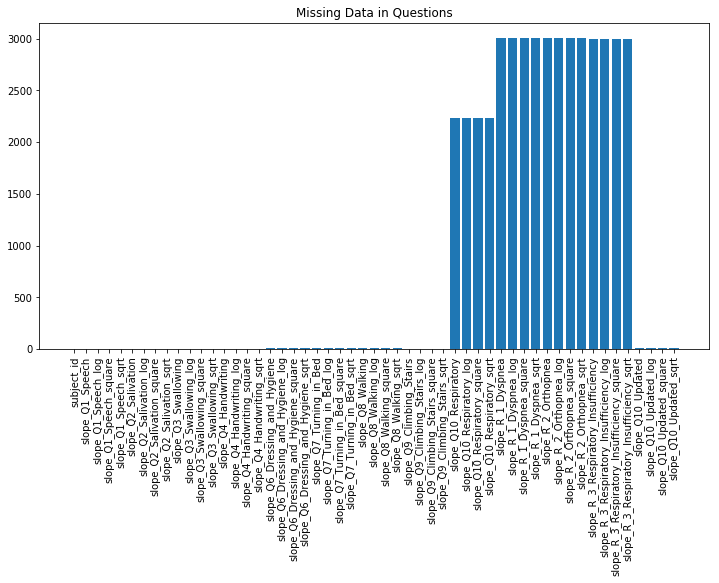

In [292]:
# number missing:
# missing columns in df
missing=[]
for col in list(questions.columns):
    missing.append(sum(questions[col].isna()))
x = np.arange(len(list(questions.columns)))
plt.figure(figsize=(12,6))
plt.bar(x=x, height=missing)
plt.xticks(x, list(questions.columns), rotation='vertical')
plt.title("Missing Data in Questions")
plt.show()

In [293]:
# merge the questions with df
df = df.merge(questions, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10332, 78)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,slope_R_2_Orthopnea_square,slope_R_2_Orthopnea_sqrt,slope_R_3_Respiratory_Insufficiency,slope_R_3_Respiratory_Insufficiency_log,slope_R_3_Respiratory_Insufficiency_square,slope_R_3_Respiratory_Insufficiency_sqrt,slope_Q10_Updated,slope_Q10_Updated_log,slope_Q10_Updated_square,slope_Q10_Updated_sqrt
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.00054,0.015706,2.919784e-07,1.007884
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,0.0,1.006232,0.0,0.01216,0.0,1.006098,0.00000,0.016238,0.000000e+00,1.008152
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add POLY Onset-anchored Individual Assessment slopes

In [331]:
q1_poly_slopes = pd.read_csv('clean_data/q1_poly_slopes.csv')
q2_poly_slopes = pd.read_csv('clean_data/q2_poly_slopes.csv')
q3_poly_slopes = pd.read_csv('clean_data/q3_poly_slopes.csv')
q4_poly_slopes = pd.read_csv('clean_data/q4_poly_slopes.csv')
q6_poly_slopes = pd.read_csv('clean_data/q6_poly_slopes.csv')
q7_poly_slopes = pd.read_csv('clean_data/q7_poly_slopes.csv')
q8_poly_slopes = pd.read_csv('clean_data/q8_poly_slopes.csv')
q9_poly_slopes = pd.read_csv('clean_data/q9_poly_slopes.csv')
q10_updated_poly_slopes = pd.read_csv('clean_data/q10_updated_poly_slopes.csv')

In [332]:
files = [q2_poly_slopes , q3_poly_slopes, q4_poly_slopes, q6_poly_slopes, 
         q7_poly_slopes, q8_poly_slopes, q9_poly_slopes, q10_updated_poly_slopes]

In [333]:
# merge into one
questions_poly = q1_poly_slopes
for file in files:
    questions_poly = questions_poly.merge(file, how='outer', on='subject_id')

In [334]:
print(questions_poly.shape)
questions_poly.head()

(6260, 28)


,subject_id,first_coef_Q1_Speech,second_coef_Q1_Speech,third_coef_Q1_Speech,first_coef_Q2_Salivation,second_coef_Q2_Salivation,third_coef_Q2_Salivation,first_coef_Q3_Swallowing,second_coef_Q3_Swallowing,third_coef_Q3_Swallowing,...,third_coef_Q7_Turning_in_Bed,first_coef_Q8_Walking,second_coef_Q8_Walking,third_coef_Q8_Walking,first_coef_Q9_Climbing_Stairs,second_coef_Q9_Climbing_Stairs,third_coef_Q9_Climbing_Stairs,first_coef_Q10_Updated,second_coef_Q10_Updated,third_coef_Q10_Updated
0,329,0.0,-2.969513e-04,1.363707e-07,0.0,-4.924070e-04,-2.886368e-08,0.0,-1.615161e-05,-1.687104e-08,...,3.670426e-07,0.0,-0.002184,5.945044e-07,0.0,-0.002364,4.457790e-07,0.0,0.000734,-6.737255e-07
1,348,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,-3.705538e-06,0.0,-0.005804,4.128728e-06,0.0,-0.007974,4.888841e-06,0.0,0.000000,0.000000e+00
2,533,0.0,-2.290738e-03,-5.756304e-07,0.0,-2.321711e-03,7.560879e-08,0.0,8.085095e-04,-2.422393e-06,...,0.000000e+00,0.0,-0.002969,2.254831e-06,0.0,0.000013,-9.018697e-07,0.0,-0.002401,1.420521e-06
3,586,0.0,-1.080652e-08,-7.759081e-06,0.0,-5.403259e-09,-3.879540e-06,0.0,-8.104889e-09,-5.819310e-06,...,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000e+00
4,649,0.0,4.754475e-04,-4.880259e-06,0.0,-3.254869e-03,2.594841e-06,0.0,-2.469378e-03,-1.040237e-06,...,-1.765158e-06,0.0,0.001294,-3.706367e-06,0.0,0.003382,-7.357748e-06,0.0,0.001179,-1.765158e-06


In [335]:
# merge the questions with df
df = df.merge(questions_poly, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10372, 139)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,third_coef_Q7_Turning_in_Bed,first_coef_Q8_Walking,second_coef_Q8_Walking,third_coef_Q8_Walking,first_coef_Q9_Climbing_Stairs,second_coef_Q9_Climbing_Stairs,third_coef_Q9_Climbing_Stairs,first_coef_Q10_Updated,second_coef_Q10_Updated,third_coef_Q10_Updated
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,3.670426e-07,0.0,-0.002184,5.945044e-07,0.0,-0.002364,4.457790e-07,0.0,0.000734,-6.737255e-07
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,-3.705538e-06,0.0,-0.005804,4.128728e-06,0.0,-0.007974,4.888841e-06,0.0,0.000000,0.000000e+00
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add the onset symptom data

In [294]:
symptom = pd.read_csv("clean_data/symptom_onset.csv")
print(symptom.shape)
symptom.head()

(2219, 29)


,subject_id,right_side,left_side,bilateral_side,loc_general,loc_trunk,loc_face,loc_mouth,loc_speech,loc_speech_or_mouth,...,symptom_atrophy,symptom_cramps,symptom_fasciculations,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness
0,649,0,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,1,0,0,1
1,1234,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,1,0
2,2540,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2956,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3085,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0


In [295]:
# merge with previous data
df = df.merge(symptom, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10341, 106)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,symptom_atrophy,symptom_cramps,symptom_fasciculations,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add weights

In [296]:
weight=pd.read_csv("clean_data/weight.csv")
print(weight.shape)
weight.head()

(6627, 2)


,subject_id,weight
0,329,52.2
1,348,118.8
2,533,51.0
3,586,61.8
4,649,73.7


In [297]:
df = df.merge(weight, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10366, 107)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,symptom_cramps,symptom_fasciculations,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness,weight
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.2
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.8
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add onset anchored FVC slopes

In [298]:
fvc = pd.read_csv("clean_data/fvc_slope.csv")
print(fvc.shape)
fvc.head()

(2809, 2)


,subject_id,slope_pct_of_Normal_Trial_1
0,329,-0.002073
1,533,-0.022895
2,586,-0.097493
3,708,-0.047942
4,902,-0.019204


In [299]:
fvc['slope_pct_of_Normal_Trial_1_square']= fvc['slope_pct_of_Normal_Trial_1']**2
fvc.head()

,subject_id,slope_pct_of_Normal_Trial_1,slope_pct_of_Normal_Trial_1_square
0,329,-0.002073,0.000004
1,533,-0.022895,0.000524
2,586,-0.097493,0.009505
3,708,-0.047942,0.002298
4,902,-0.019204,0.000369


In [300]:
df = df.merge(fvc, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10372, 109)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness,weight,slope_pct_of_Normal_Trial_1,slope_pct_of_Normal_Trial_1_square
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.2,-0.002073,0.000004
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.8,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# End of DF

## Add delta individual question data

In [168]:
scores = pd.read_csv("clean_data/scores_delta.csv")
print(scores.shape)
scores.head()

(6683, 16)


,subject_id,day_since_onset,time_delta_Q1_Speech,time_delta_Q2_Salivation,time_delta_Q3_Swallowing,time_delta_Q4_Handwriting,time_delta_Q5a_Cutting_without_Gastrostomy,time_delta_Q5b_Cutting_with_Gastrostomy,time_delta_Q6_Dressing_and_Hygiene,time_delta_Q7_Turning_in_Bed,time_delta_Q8_Walking,time_delta_Q9_Climbing_Stairs,time_delta_Q10_Respiratory,time_delta_R_1_Dyspnea,time_delta_R_2_Orthopnea,time_delta_R_3_Respiratory_Insufficiency
0,329,1980.0,0.000000,0.000505,0.000000,0.000505,0.001515,NaN,0.001010,0.001010,0.001010,0.001515,0.000505,NaN,NaN,NaN
1,348,902.0,0.000000,0.000000,0.000000,0.000000,0.003326,NaN,0.002217,0.002217,0.002217,0.003326,NaN,0.000000,0.0,0.0
2,533,1401.0,0.002855,0.002855,0.002855,0.000714,NaN,0.000000,0.000714,0.000000,0.000000,0.002141,0.000714,0.000714,0.0,0.0
3,586,718.0,0.005571,0.002786,0.004178,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.0,0.0
4,649,898.0,0.004454,0.001114,0.003341,0.001114,NaN,0.001114,0.002227,0.001114,0.002227,0.003341,0.001114,NaN,NaN,NaN


In [39]:
# drop columns
scores.drop('day_since_onset', axis=1, inplace=True)

In [40]:
# merge with df
df = df.merge(scores, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10342, 65)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,time_delta_Q5a_Cutting_without_Gastrostomy,time_delta_Q5b_Cutting_with_Gastrostomy,time_delta_Q6_Dressing_and_Hygiene,time_delta_Q7_Turning_in_Bed,time_delta_Q8_Walking,time_delta_Q9_Climbing_Stairs,time_delta_Q10_Respiratory,time_delta_R_1_Dyspnea,time_delta_R_2_Orthopnea,time_delta_R_3_Respiratory_Insufficiency
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,0.001515,NaN,0.001010,0.001010,0.001010,0.001515,0.000505,NaN,NaN,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,0.003326,NaN,0.002217,0.002217,0.002217,0.003326,NaN,0.0,0.0,0.0
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add non-anchored FVC slopes
study day slopes (not onset anchored)

In [89]:
fvc_slope_liters = pd.read_csv("clean_data/fvc_liters_slope.csv")
print(fvc_slope_liters.shape)
fvc_slope_liters.head()

(6173, 2)


,subject_id,slope_fvc_liters
0,329,-0.000990
1,533,-0.013333
2,649,-0.003282
3,708,-0.004433
4,902,-0.001505


In [90]:
df = df.merge(fvc_slope_liters, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10546, 55)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness,weight,slope_pct_of_Normal_Trial_1,slope_pct_of_Normal_Trial_1_log,slope_fvc_liters
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,52.2,-0.002073,1.803276,-0.00099
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,118.8,NaN,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Death buckets

In [41]:
death_buckets = pd.read_csv("clean_data/death_buckets.csv")
print(death_buckets.shape)
death_buckets.head()

(6868, 12)


,subject_id,died_1,died_2,died_3,died_4,died_5,died_6,died_7,died_8,died_9,died_10,died_greater_10
0,329,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,348,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,533,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,586,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,649,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# merge death buckets with df
df = df.merge(death_buckets, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10549, 90)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,died_2,died_3,died_4,died_5,died_6,died_7,died_8,died_9,died_10,died_greater_10
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add the lab slopes

In [43]:
from os import listdir
from os.path import isfile, join
mypath = 'clean_lab/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [44]:
lab_dfs = []
for file in onlyfiles:
    file_p = mypath+file
    lab_dfs.append(pd.read_csv(file_p))

In [45]:
p = lab_dfs.pop()

In [46]:
lab_slopes = p

In [47]:
for lab_table in lab_dfs:
    lab_slopes = lab_slopes.merge(lab_table, how='outer', on='subject_id')

In [48]:
lab_slopes.head()

,subject_id,slope_white blood cell (wbc),slope_absolute band neutrophil count,slope_absolute basophil count,slope_absolute lymphocyte count,slope_absolute monocyte count,slope_absolute neutrophil count,slope_absolute segmented neutrophil count,slope_albumin,slope_aldolase,...,slope_urine albumin,slope_urine collection duration,slope_urine creatinine clearance,slope_urine creatinine,slope_urine hyaline cast,slope_urine microalbumin,slope_urine ph,slope_urine specific gravity,slope_urine volume,slope_vitamin e
0,329,-0.009341,NaN,NaN,NaN,NaN,NaN,NaN,-0.011345,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
1,348,-0.002182,NaN,-0.000012,0.000621,0.000055,-0.002798,-0.002798,0.009067,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000346,-0.000002,NaN,NaN
2,533,-0.006518,NaN,NaN,NaN,NaN,NaN,NaN,0.060871,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,649,-0.003398,NaN,-0.000007,-0.001154,-0.000243,-0.002022,NaN,-0.001626,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000268,NaN,NaN,NaN
4,708,-0.000607,NaN,NaN,NaN,NaN,NaN,NaN,-0.029895,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN


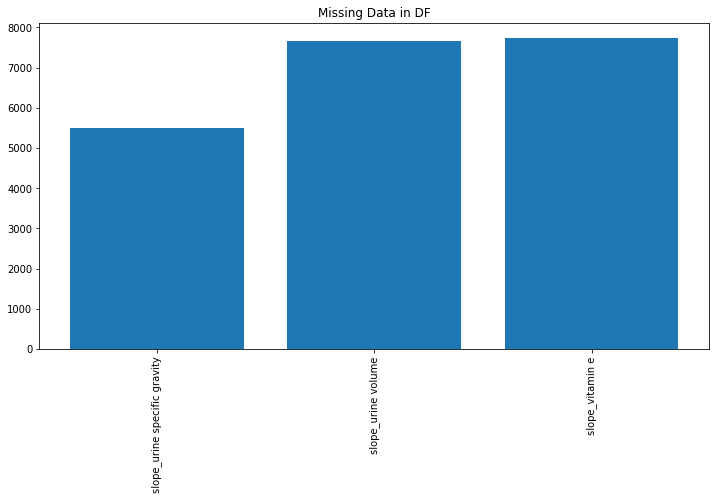

In [49]:
# determine how many missing data there are. which values to keep
missing=[]
limited_df = lab_slopes.iloc[:,80:90].copy()
for col in list(limited_df.columns):
    missing.append(sum(limited_df[col].isna()))
x = np.arange(len(list(limited_df.columns)))
plt.figure(figsize=(12,6))
plt.bar(x=x, height=missing)
plt.xticks(x, list(limited_df.columns), rotation='vertical')
plt.title("Missing Data in DF")
plt.show()

In [50]:
lab_slopes_include = [ 'subject_id', 
    'slope_white blood cell (wbc)', 'slope_absolute basophil count',
    'slope_absolute lymphocyte count', 'slope_absolute monocyte count',
    'slope_absolute neutrophil count', 
    'slope_albumin', 'slope_alkaline phosphatase', 
    'slope_alt(sgpt)', 'slope_ast(sgot)', 'slope_basophils', 'slope_bicarbonate',
    'slope_blood urea nitrogen (bun)', 'slope_calcium', 'slope_chloride', 
    'slope_creatinine', 'slope_eosinophils', 'slope_gamma-glutamyltransferase',
    'slope_hematocrit', 'slope_hemoglobin', 'slope_lymphocytes',
     'slope_monocytes', 'slope_phosphorus', 'slope_platelets', 'slope_protein',
    'slope_red blood cells (rbc)', 'slope_sodium', 
    ]

In [51]:
lab_slopes_model=lab_slopes[lab_slopes_include].copy()

In [52]:
# merge lab slopes with df
df = df.merge(lab_slopes_model, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10653, 116)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,slope_gamma-glutamyltransferase,slope_hematocrit,slope_hemoglobin,slope_lymphocytes,slope_monocytes,slope_phosphorus,slope_platelets,slope_protein,slope_red blood cells (rbc),slope_sodium
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,NaN,-0.012758,-0.019909,-0.004368,0.001936,0.000285,0.503324,0.015361,-4.481578,0.006124
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,0.004629,0.002251,0.003742,0.016732,0.002372,0.000733,0.029351,0.006712,0.184799,-0.002977
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# DF - Overview of all Features 

### Mean of all features

In [382]:
df.dtypes.value_counts()

float64    137
object       1
int64        1
dtype: int64

In [381]:
df['Study_Arm'].dtype!='O'

False

In [410]:
df_dict = {}
temp_df = df.copy()
temp_df = temp_df.drop(['Study_Arm','subject_id'],axis=1)
for feat in list(temp_df.columns):
    feat_df = temp_df[feat].dropna()
    #summary_df[feat].value_counts().max()
    most_common = feat_df.value_counts().idxmax()
    mean_val = feat_df.mean()
    df_dict[feat] = [most_common, mean_val]
summary_df = pd.DataFrame(df_dict)

In [412]:
# save summary_df as csv
filename = 'website/baseline_df.csv'
summary_df.to_csv(filename, index=False)

In [246]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'delta_onset_diag',
       'death_day_since_onset', 'death_day_mean_delta', 'death_week',
       ...
       'slope_R_1_Dyspnea_square', 'slope_R_1_Dyspnea_sqrt',
       'slope_R_2_Orthopnea', 'slope_R_2_Orthopnea_log',
       'slope_R_2_Orthopnea_square', 'slope_R_2_Orthopnea_sqrt',
       'slope_R_3_Respiratory_Insufficiency',
       'slope_R_3_Respiratory_Insufficiency_log',
       'slope_R_3_Respiratory_Insufficiency_square',
       'slope_R_3_Respiratory_Insufficiency_sqrt'],
      dtype='object', length=105)

## Plot death days

In [247]:
# limit to placebo subjects.
placebo = df[ df['Study_Arm']=='Placebo' ].copy()

/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


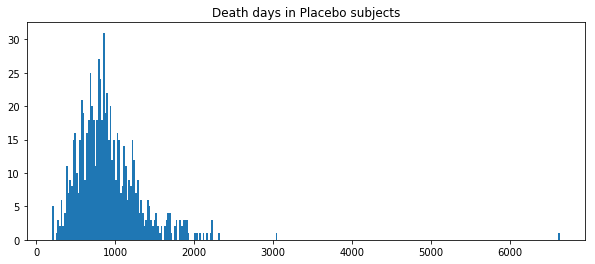

In [248]:
plt.figure(figsize=(10,4))
plt.hist(placebo['death_day_since_onset'], bins = 300)#, edgecolor="white")
plt.title('Death days in Placebo subjects')
plt.show()

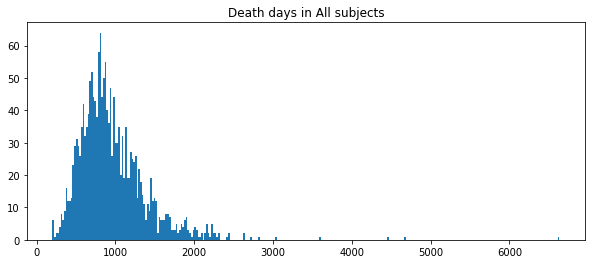

In [249]:
plt.figure(figsize=(10,4))
plt.hist(df['death_day_since_onset'], bins = 300)#, edgecolor="white")
plt.title('Death days in All subjects')
plt.show()

## Plot missing values in df

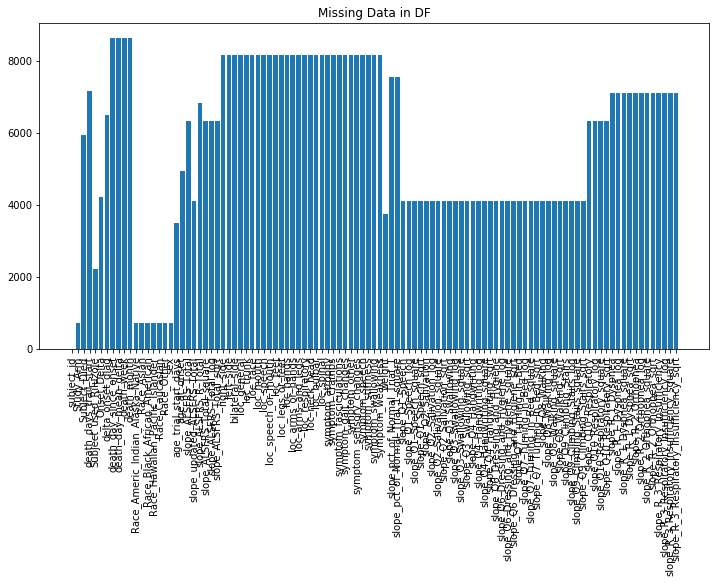

In [250]:
# missing columns in df
missing=[]
limited_df = df.copy()
for col in list(limited_df.columns):
    missing.append(sum(limited_df[col].isna()))
x = np.arange(len(list(limited_df.columns)))
plt.figure(figsize=(12,6))
plt.bar(x=x, height=missing)
plt.xticks(x, list(limited_df.columns), rotation='vertical')
plt.title("Missing Data in DF")
plt.show()

### distribution of death days by location

In [251]:
# loc_speech_or_mouth
def plot_feature_by_death(df, col):
    print("Number of subjects: {}".format(len(df[ df[col]==1]['death_day_since_onset'])))
    plt.hist(df[ df[col]==1]['death_day_since_onset'], bins=50,
            ec="white")
    plt.title(col)
    plt.xlim(0,4000)
    plt.axvline(1800, color="red")
    plt.show()
    mean_death = df[ df[col]==1]['death_day_since_onset'].mean()
    print("mean day from onset to death = {}".format(mean_death))
    return mean_death

Number of subjects: 493


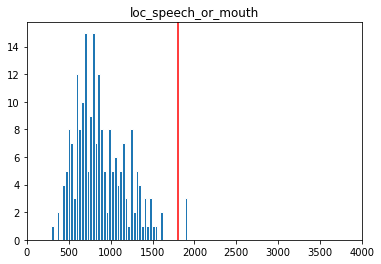

mean day from onset to death = 881.1563981042653


In [252]:
speech_mouth = plot_feature_by_death(df, 'loc_speech_or_mouth')

Number of subjects: 499


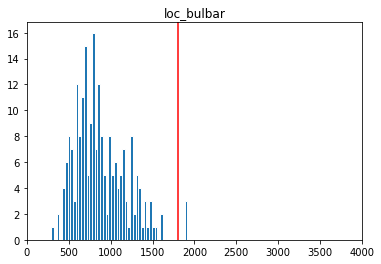

mean day from onset to death = 877.8644859813085


In [253]:
feet = plot_feature_by_death(df, 'loc_bulbar')

Number of subjects: 1775


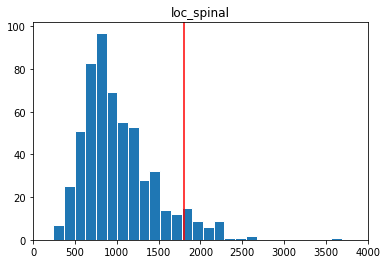

mean day from onset to death = 1037.6660839160838


In [254]:
legs_or_feet = plot_feature_by_death(df, 'loc_spinal')

Number of subjects: 83


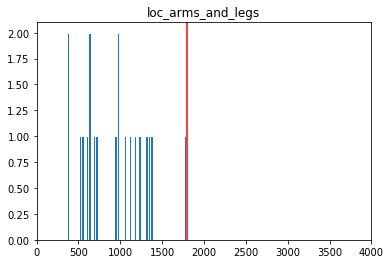

mean day from onset to death = 915.6


In [255]:
arms_and_legs = plot_feature_by_death(df, 'loc_arms_and_legs')

Number of subjects: 529


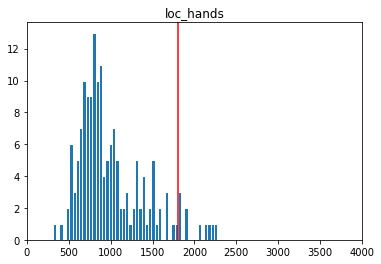

mean day from onset to death = 1003.4285714285714


In [256]:
hands = plot_feature_by_death(df, 'loc_hands')

In [257]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'delta_onset_diag',
       'death_day_since_onset', 'death_day_mean_delta', 'death_week',
       ...
       'slope_R_1_Dyspnea_square', 'slope_R_1_Dyspnea_sqrt',
       'slope_R_2_Orthopnea', 'slope_R_2_Orthopnea_log',
       'slope_R_2_Orthopnea_square', 'slope_R_2_Orthopnea_sqrt',
       'slope_R_3_Respiratory_Insufficiency',
       'slope_R_3_Respiratory_Insufficiency_log',
       'slope_R_3_Respiratory_Insufficiency_square',
       'slope_R_3_Respiratory_Insufficiency_sqrt'],
      dtype='object', length=105)

## Plot individual feautures in respect to target

In [258]:
ff = ['slope_ALSFRS_Total', 'slope_ALSFRS_Total_square', 'slope_ALSFRS_Total_sqrt']

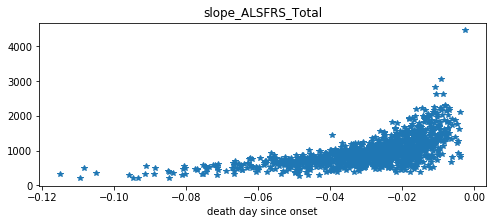

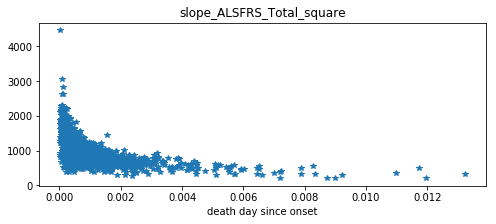

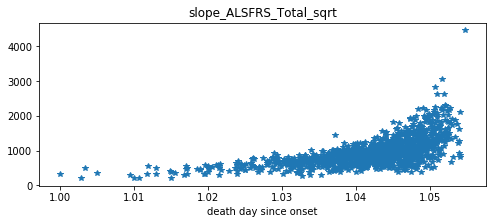

In [259]:
for feat in list(ff):
    plt.figure(figsize=(8,3))
    plt.plot( df[feat], df['death_day_since_onset'], '*')
    plt.title(feat)
    plt.xlabel("death day since onset")
    plt.show()

In [38]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'delta_onset_diag',
       'death_day_since_onset', 'death_day_mean_delta', 'death_week',
       'death_month', 'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Caucasian', 'Race_Other', 'sex', 'age_trial_start_days',
       'age_at_onset', 'scale', 'slope', 'intercept', 'right_side',
       'left_side', 'bilateral_side', 'loc_general', 'loc_trunk', 'loc_face',
       'loc_mouth', 'loc_speech', 'loc_speech_or_mouth', 'loc_feet',
       'loc_legs_or_feet', 'loc_hands', 'loc_arms_or_hands',
       'loc_arms_and_legs', 'loc_respiratory', 'loc_neck_head', 'loc_bulbar',
       'loc_spinal', 'symptom_atrophy', 'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 'symptom_speech', 'symptom_stiffness',
       'sympto

In [39]:
# columns not the include
drop_demo = ['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
        'Onset_Delta', 'Diagnosis_Delta', 'delta_onset_diag']
drop_weight = ['weight']
drop_age = ['age_at_onset']
drop_death = ['death_day_mean_delta', 'death_week', 'death_month']
drop_race = ['Ethnicity', 'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
             'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
              'Race_Unknown', 'Race_Caucasian', 'Race_Other', 'Race_Other_Specify']
drop_other = ['scale', 'intercept']
drop_questions = ['time_delta_Q1_Speech', 'time_delta_Q2_Salivation', 
        'time_delta_Q3_Swallowing',
       'time_delta_Q4_Handwriting',
       'time_delta_Q5a_Cutting_without_Gastrostomy',
       'time_delta_Q5b_Cutting_with_Gastrostomy',
       'time_delta_Q6_Dressing_and_Hygiene', 'time_delta_Q7_Turning_in_Bed',
       'time_delta_Q8_Walking', 'time_delta_Q9_Climbing_Stairs',
       'time_delta_Q10_Respiratory', 'time_delta_R_1_Dyspnea',
       'time_delta_R_2_Orthopnea', 'time_delta_R_3_Respiratory_Insufficiency']
drop_fvc = ['slope_fvc_percent_of_normal']

In [43]:
data_to_include = ['death_day_since_onset', 'Subject_used_Riluzole', 
                   'Race_Caucasian', 'sex', 'age_at_onset', 'slope', 
                   'right_side', 'left_side', 'bilateral_side', 'loc_bulbar', 
                   'loc_spinal', 'weight',
                   'slope_fvc_liters']

In [45]:
# select the features to include in model.
pre_model_data = df[data_to_include].copy()
print(pre_model_data.shape)
pre_model_data.head()

(10546, 13)


,death_day_since_onset,Subject_used_Riluzole,Race_Caucasian,sex,age_at_onset,slope,right_side,left_side,bilateral_side,loc_bulbar,loc_spinal,weight,slope_fvc_liters
0,NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.0,0.0,42.673973,-0.007092,NaN,NaN,NaN,NaN,NaN,52.2,-0.00099
2,NaN,1.0,1.0,0.0,53.372603,-0.012720,NaN,NaN,NaN,NaN,NaN,118.8,NaN
3,NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Model Data

In [46]:
model_data = pre_model_data.copy()
print(model_data.shape)
model_data.head()

(10546, 13)


,death_day_since_onset,Subject_used_Riluzole,Race_Caucasian,sex,age_at_onset,slope,right_side,left_side,bilateral_side,loc_bulbar,loc_spinal,weight,slope_fvc_liters
0,NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.0,0.0,42.673973,-0.007092,NaN,NaN,NaN,NaN,NaN,52.2,-0.00099
2,NaN,1.0,1.0,0.0,53.372603,-0.012720,NaN,NaN,NaN,NaN,NaN,118.8,NaN
3,NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plot missing values

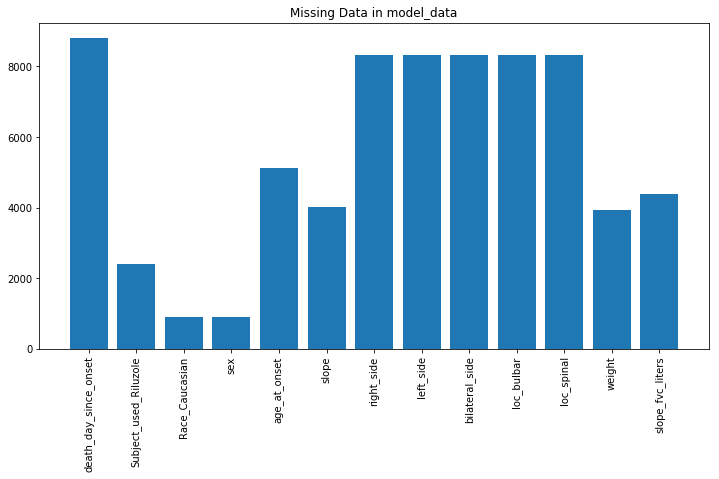

In [209]:
# missing columns in df
missing=[]
for col in list(df.columns):
    missing.append(sum(pre_model_data[col].isna()))
x = np.arange(len(list(pre_model_data.columns)))
plt.figure(figsize=(12,6))
plt.bar(x=x, height=missing)
plt.xticks(x, list(pre_model_data.columns), rotation='vertical')
plt.title("Missing Data in model_data")
plt.show()

## Plot individual features of the data

In [184]:
#limit to death days since onset not na
d_day = df [~df['death_day_since_onset'].isna()].copy()

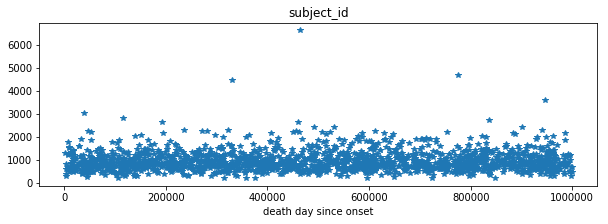

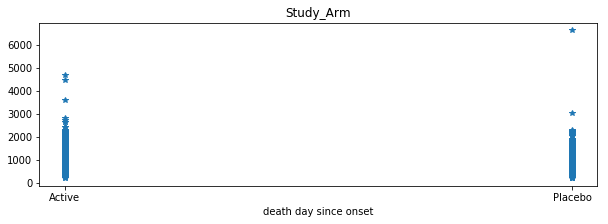

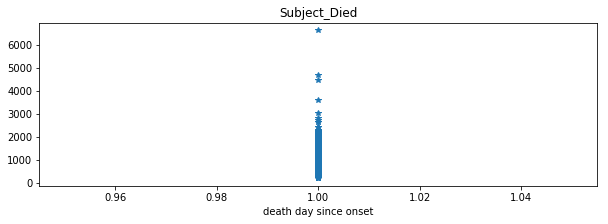

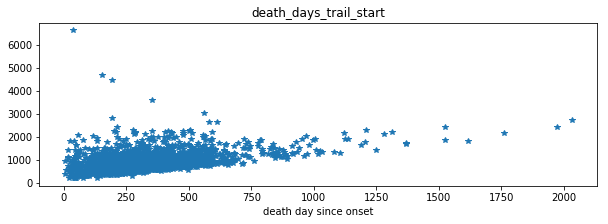

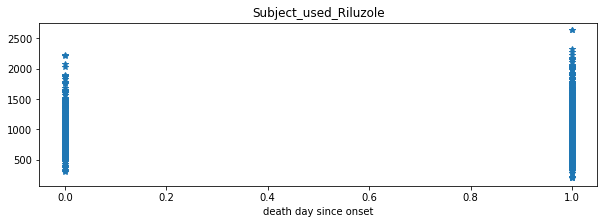

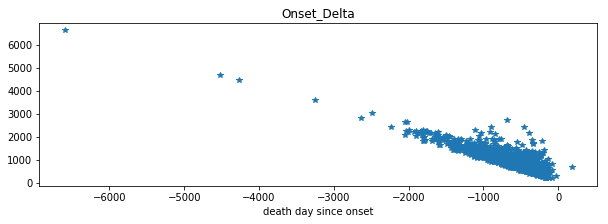

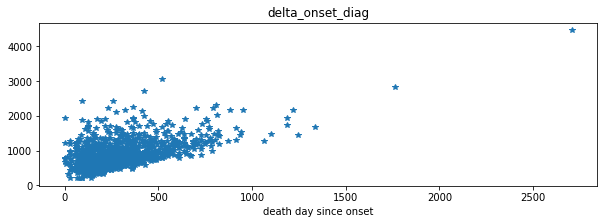

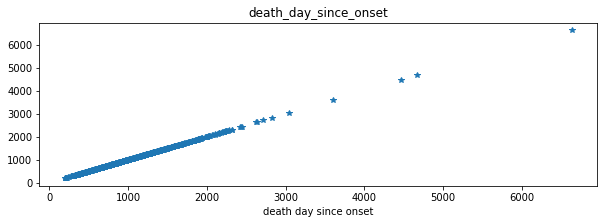

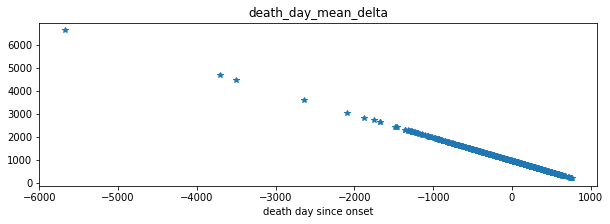

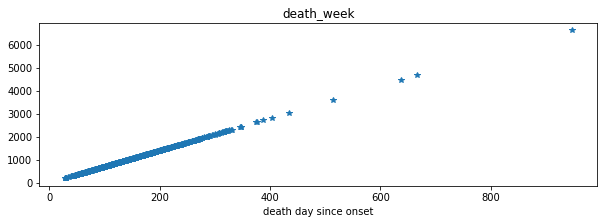

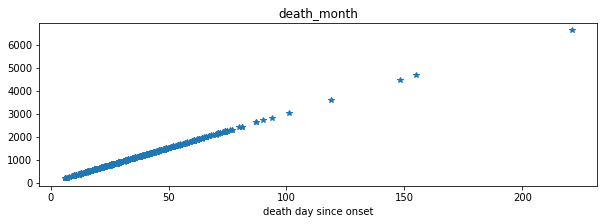

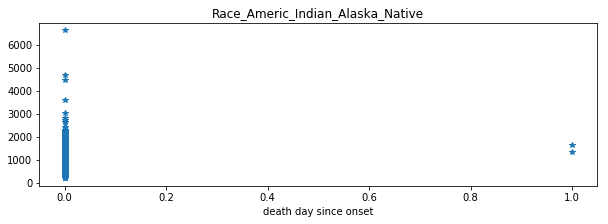

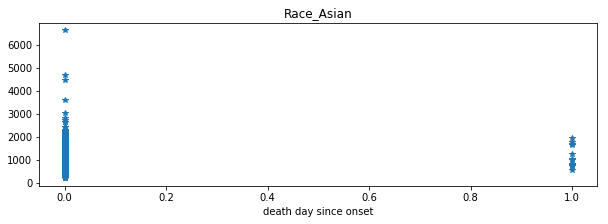

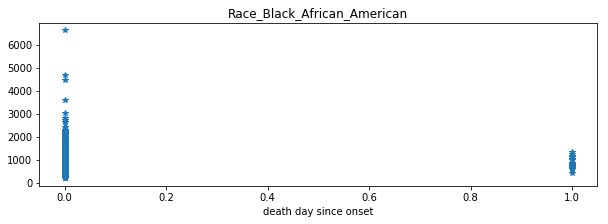

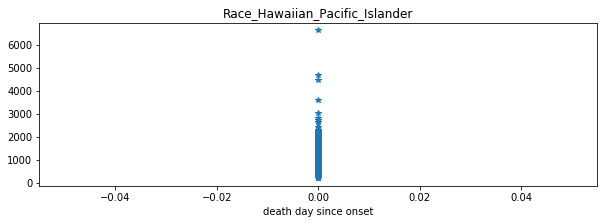

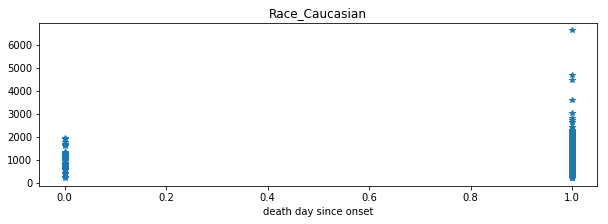

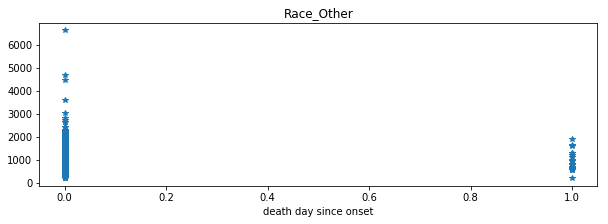

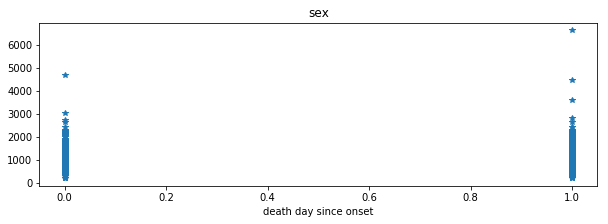

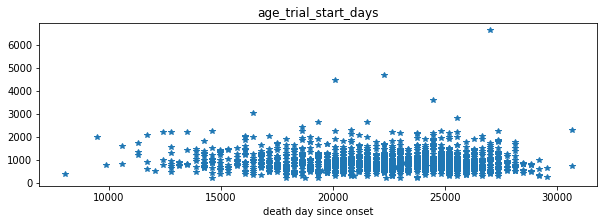

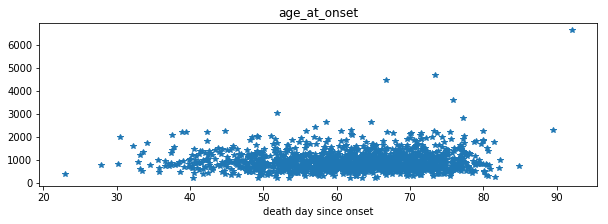

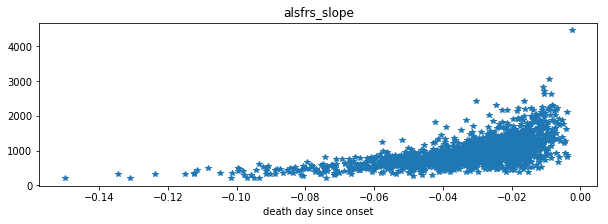

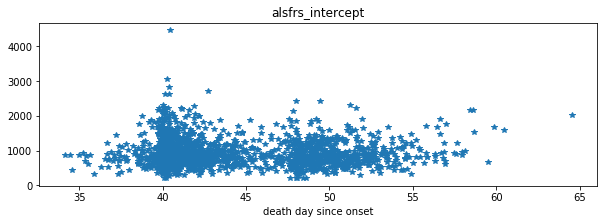

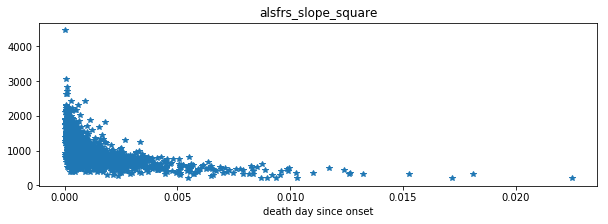

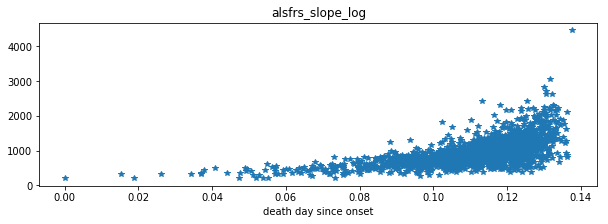

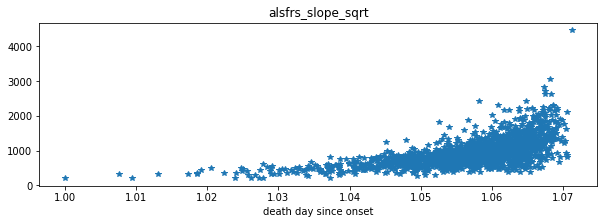

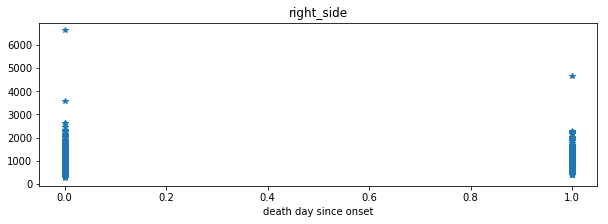

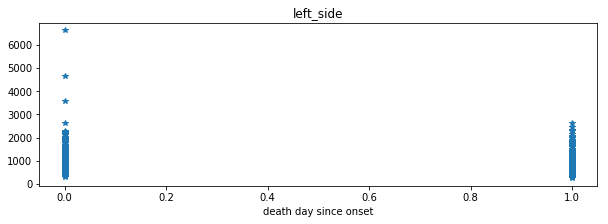

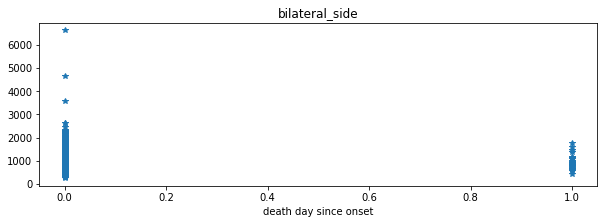

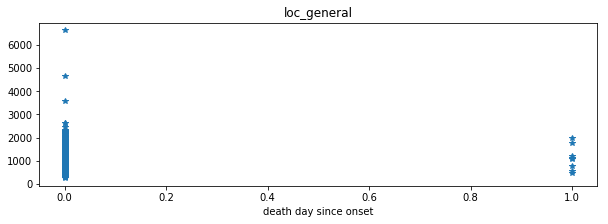

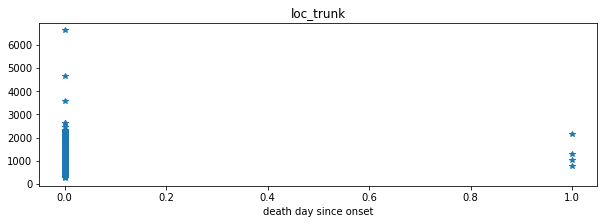

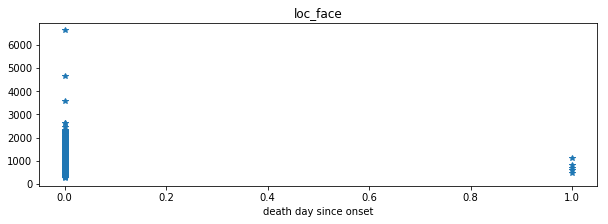

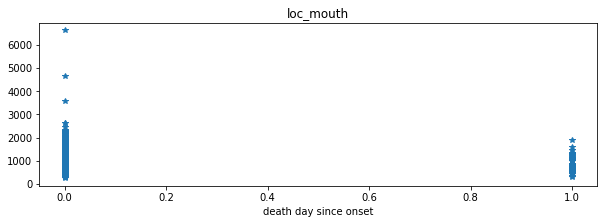

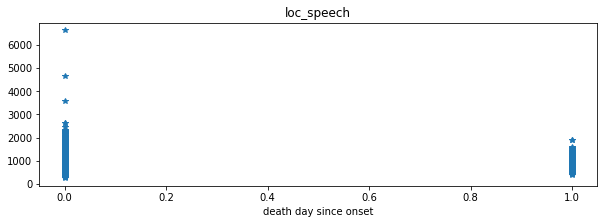

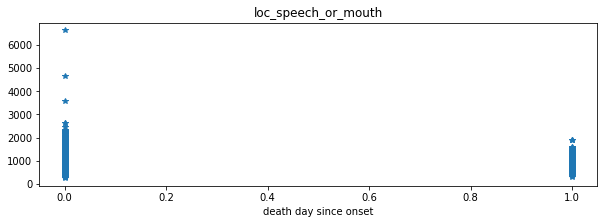

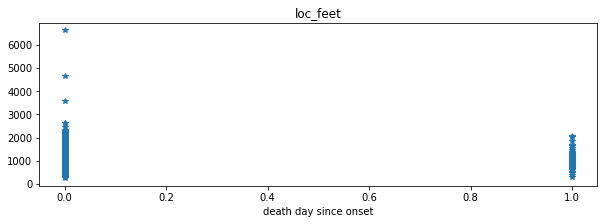

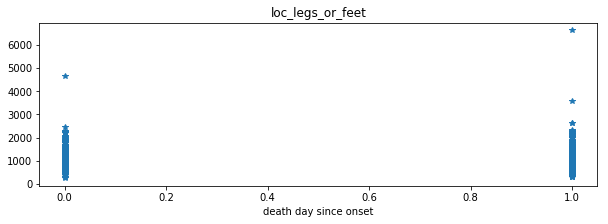

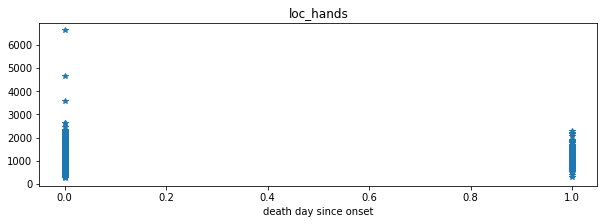

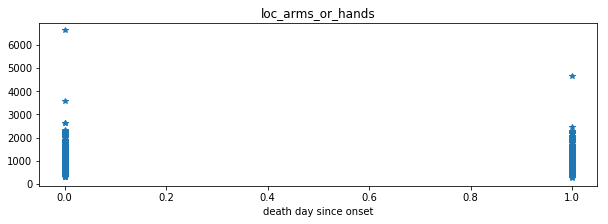

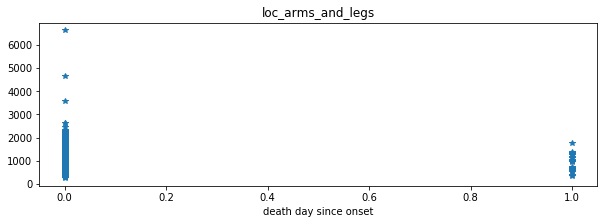

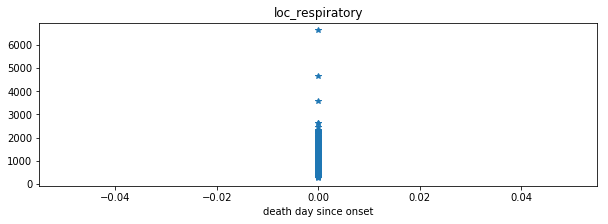

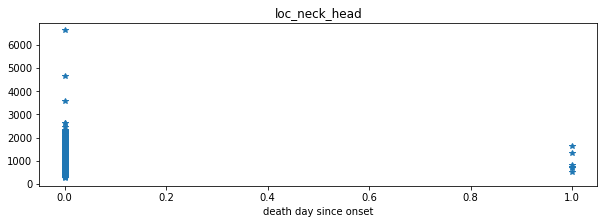

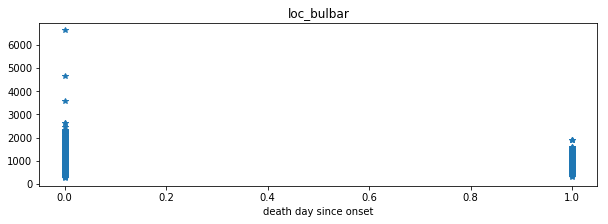

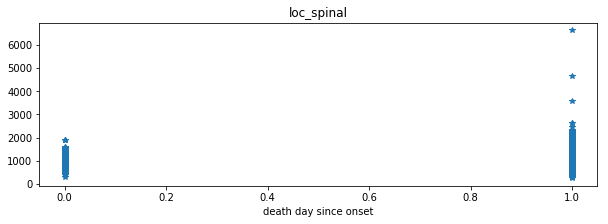

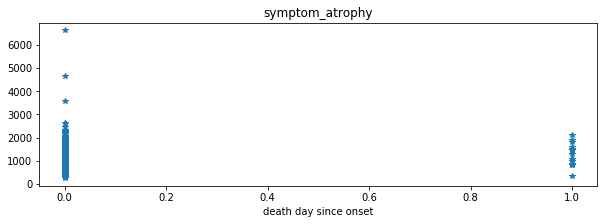

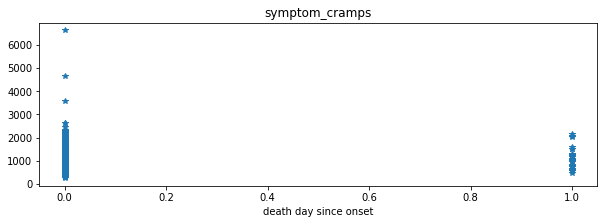

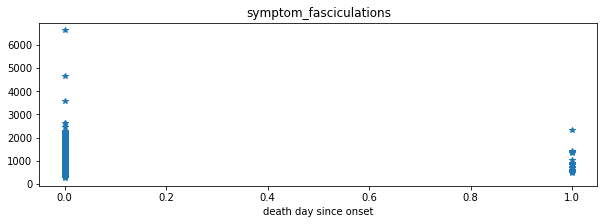

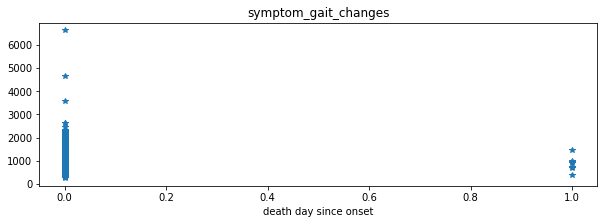

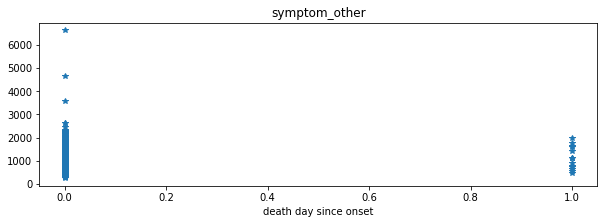

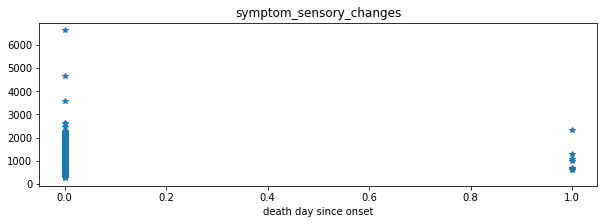

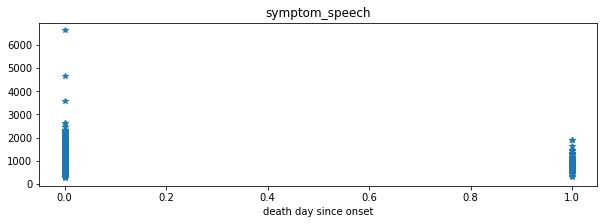

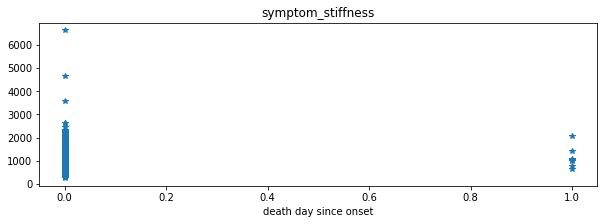

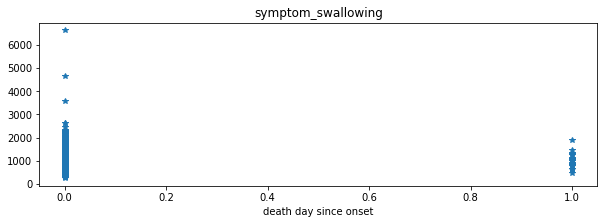

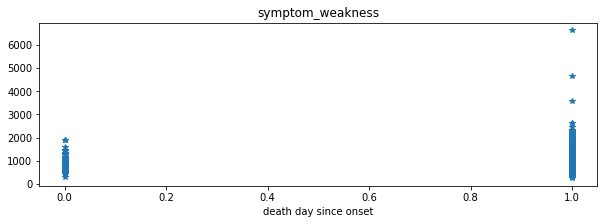

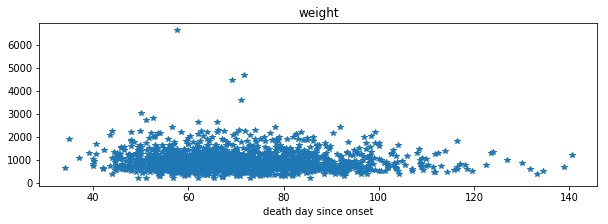

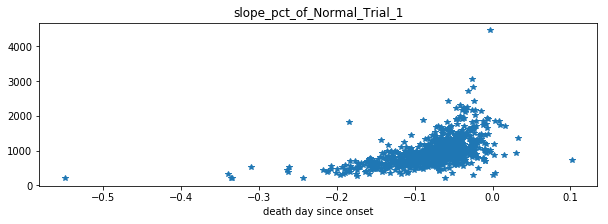

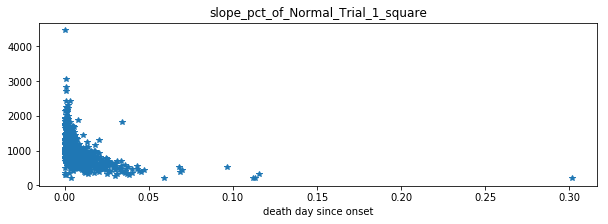

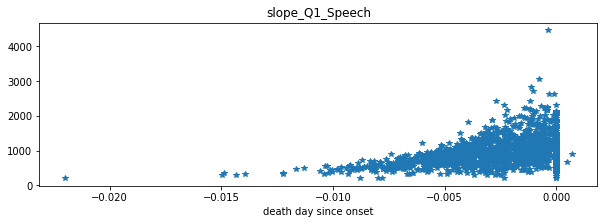

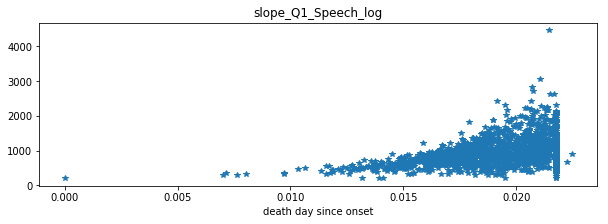

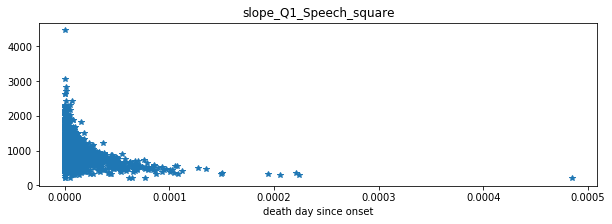

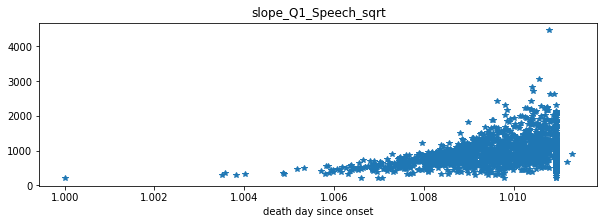

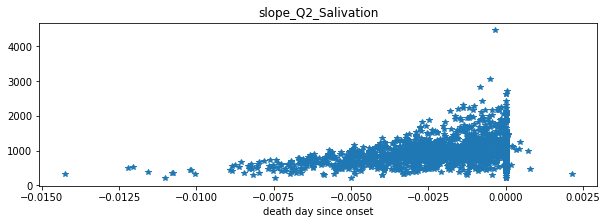

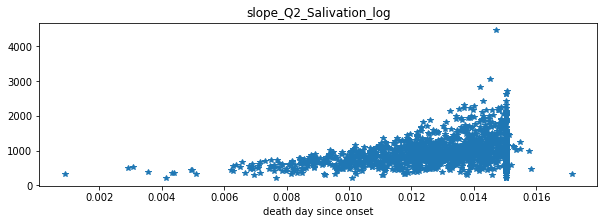

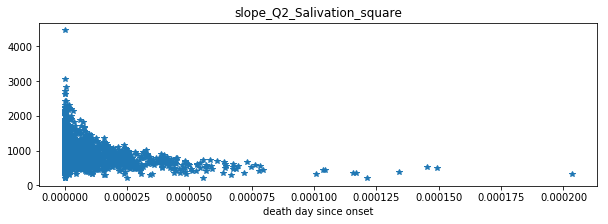

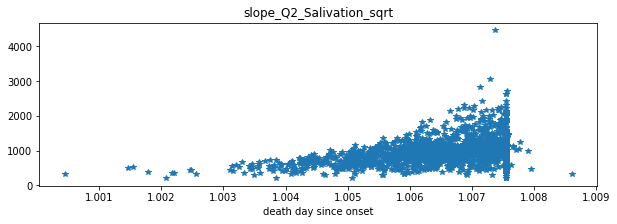

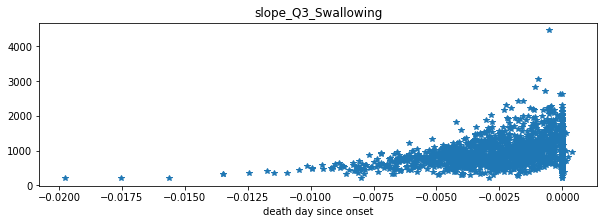

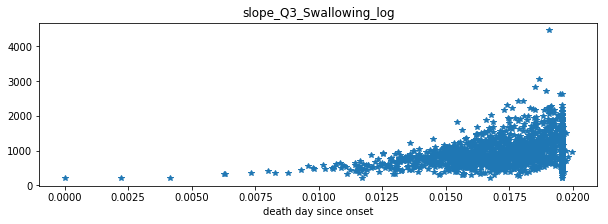

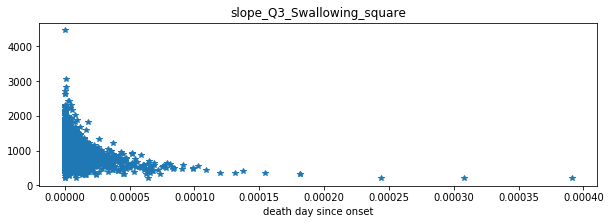

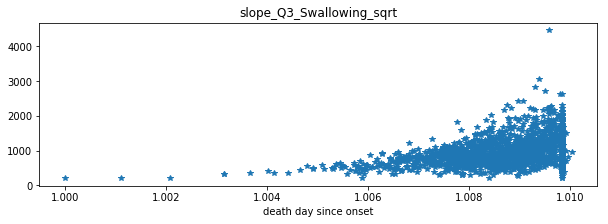

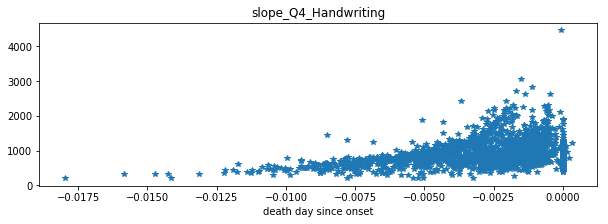

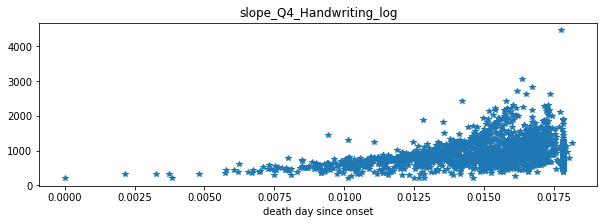

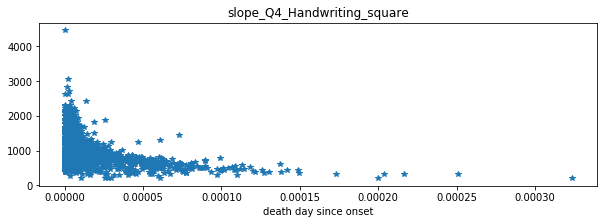

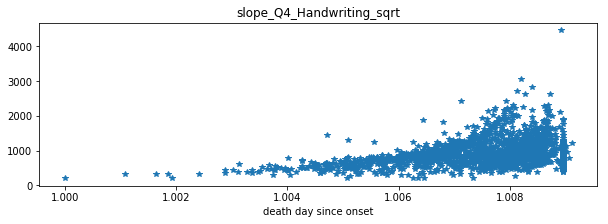

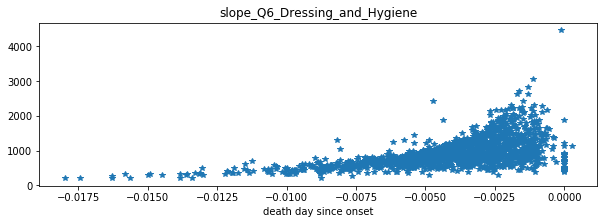

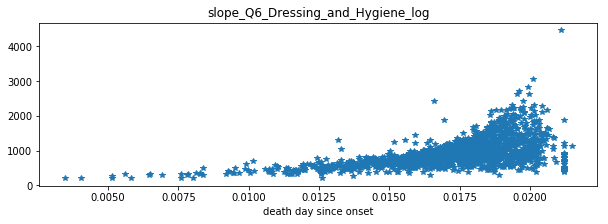

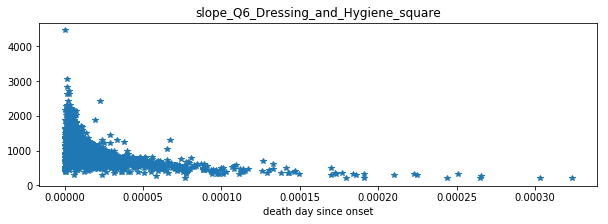

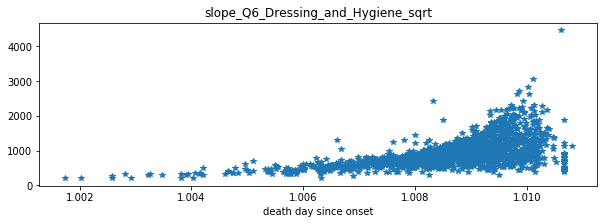

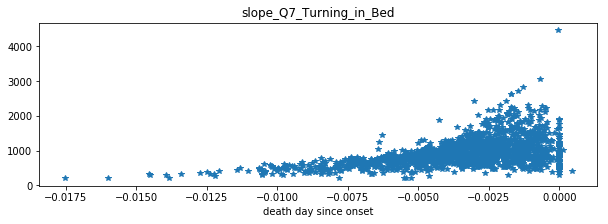

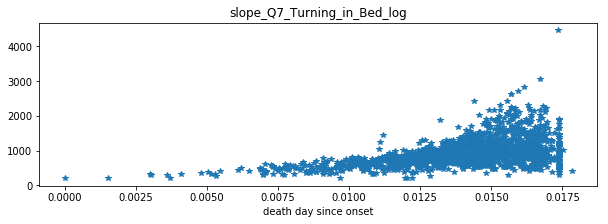

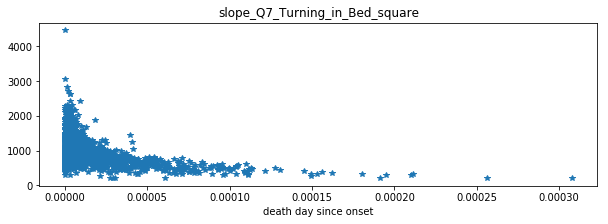

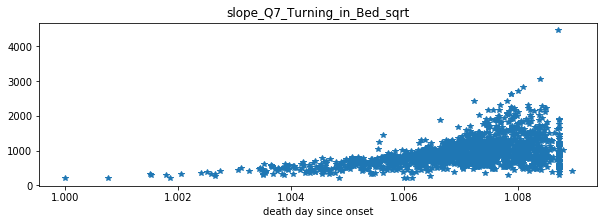

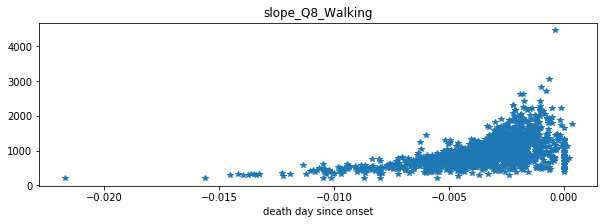

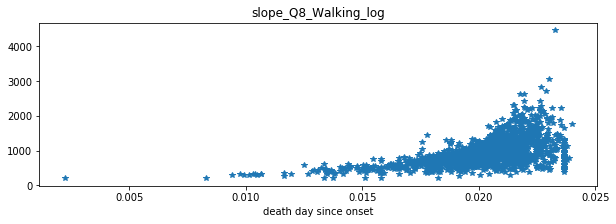

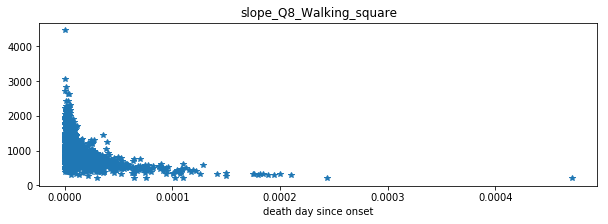

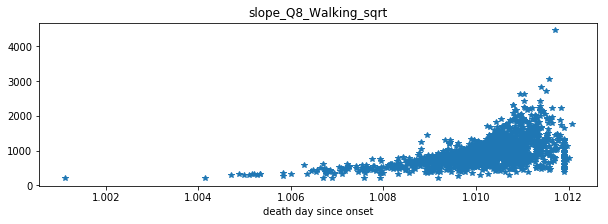

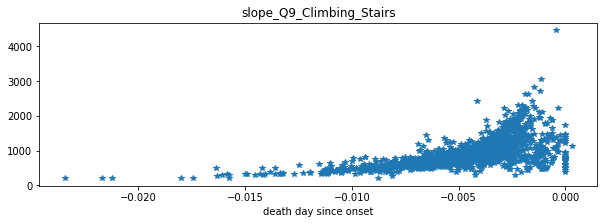

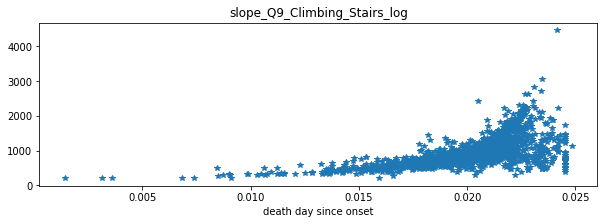

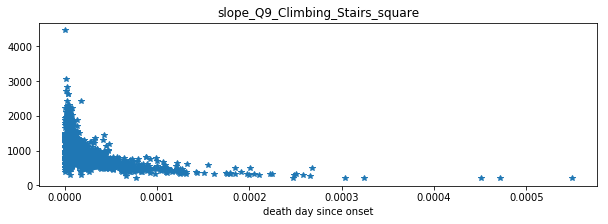

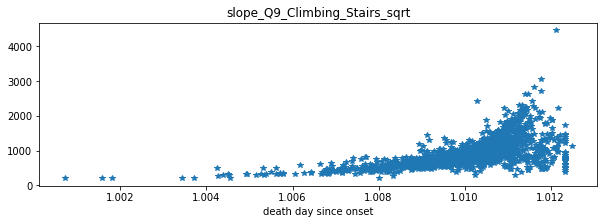

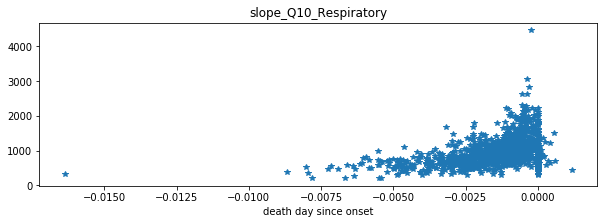

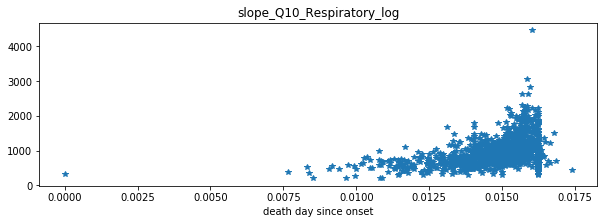

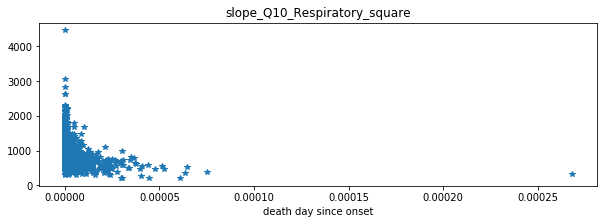

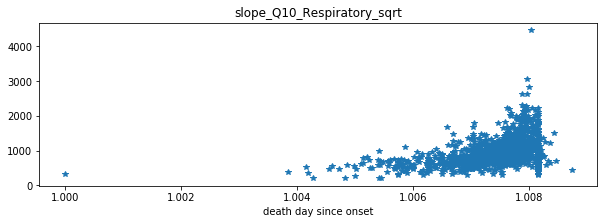

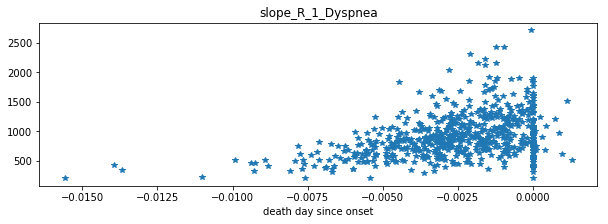

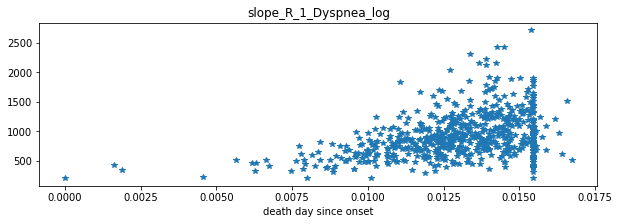

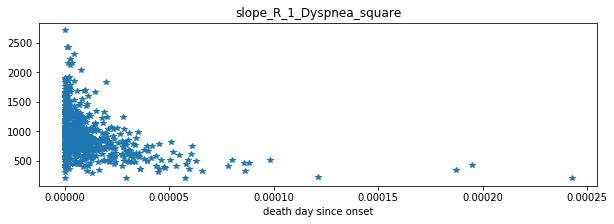

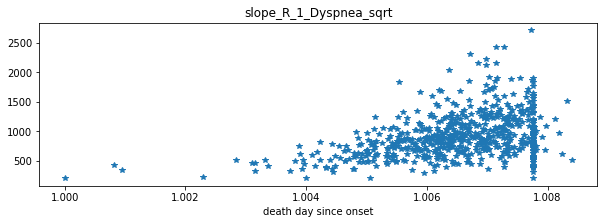

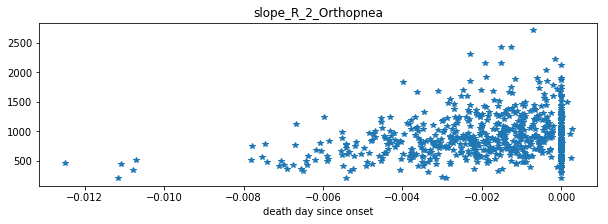

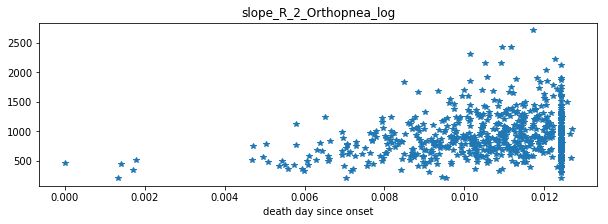

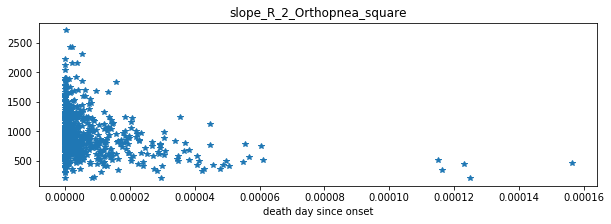

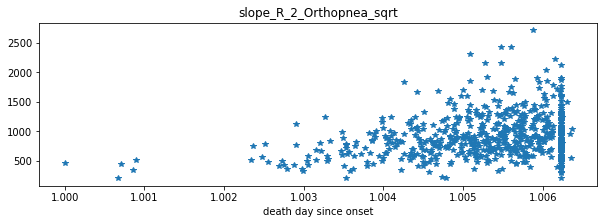

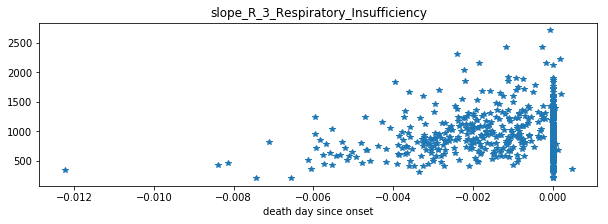

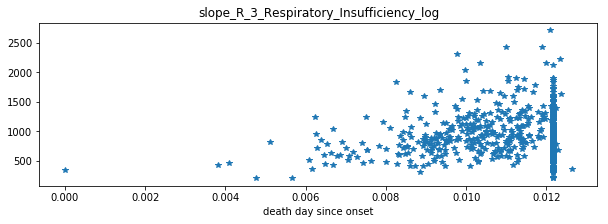

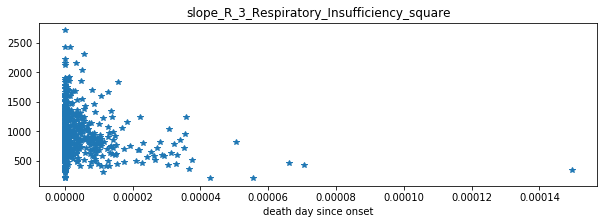

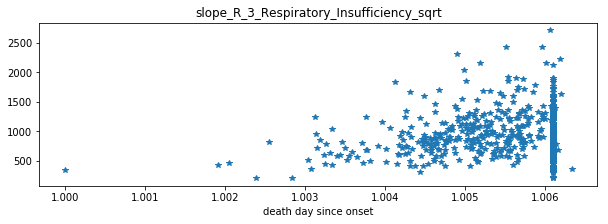

In [185]:
for feat in list(d_day.columns):
    plt.figure(figsize=(10,3))
    #sns.jointplot(X3['death_day_since_onset'], X3[feat] , kind='scatter')
    plt.plot(d_day[feat], d_day['death_day_since_onset'],'*')
    plt.title(feat)
    plt.xlabel("death day since onset")
    plt.show()

## Linear Model

In [167]:

params = {'a':1}
lm = Linear_Model('linear', X, y, params)

/Users/Shared/galvanize/als/regress_model.py:233: RuntimeWarning: invalid value encountered in log
  self.rmse_log = np.sqrt(((( np.log(self.predicted+1)-np.log(self.y_train + 1) )**2).sum() ) / len(self.y_train))


In [168]:
lm.rmse

291.88771630785067

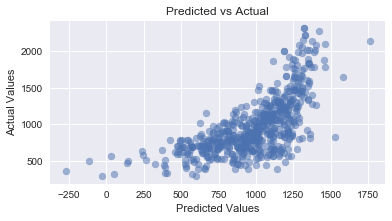

In [169]:
lm_plot(lm.predicted, lm.y_train)

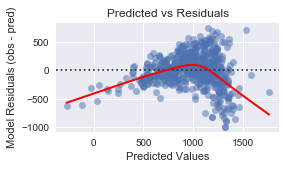

In [170]:
resid_plot(lm.predicted, lm.resid)

In [125]:
lm_data = df.copy()
lm_target = 'death_day_since_onset'
lm_features = [ 'Subject_used_Riluzole', 
       'Race_Caucasian', 'sex',
       'age_at_onset', 'right_side', 'left_side',
       'bilateral_side', 'loc_general', 'loc_trunk', 'loc_face', 'loc_mouth',
       'loc_speech', 'loc_speech_or_mouth', 'loc_feet', 'loc_legs_or_feet',
       'loc_hands', 'loc_arms_or_hands', 'loc_arms_and_legs',
       'loc_respiratory', 'loc_neck_head', 'loc_bulbar', 'loc_spinal',
       'symptom_atrophy', 'symptom_cramps', 'symptom_fasciculations',
       'symptom_gait_changes', 'symptom_other', 'symptom_sensory_changes',
       'symptom_speech', 'symptom_stiffness', 'symptom_swallowing',
       'symptom_weakness',
       'weight', 
       'slope_Q1_Speech', 'slope_Q2_Salivation', 'slope_Q3_Swallowing',
       'slope_Q4_Handwriting', 'slope_Q6_Dressing_and_Hygiene',
       'slope_Q7_Turning_in_Bed', 'slope_Q8_Walking',
       'slope_Q9_Climbing_Stairs_square']
#others: 'slope_fvc_percent_of_normal', 'slope_fvc_liters',
lm_t_f = [lm_target]+lm_features
lm_data=lm_data[lm_t_f].copy()
lm_data.dropna(inplace=True)
print(lm_data.shape)
lm_data.head()

(648, 42)


,death_day_since_onset,Subject_used_Riluzole,Race_Caucasian,sex,age_at_onset,right_side,left_side,bilateral_side,loc_general,loc_trunk,...,symptom_weakness,weight,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs_square
22,405.0,1.0,1.0,1.0,41.808219,1.0,0.0,0.0,0.0,0.0,...,1.0,74.3,0.000000,0.000000,0.000000,-0.003750,-0.008464,-0.011028,-0.011028,0.000127
32,624.0,1.0,1.0,0.0,61.191781,1.0,0.0,0.0,0.0,0.0,...,1.0,46.7,0.000000,0.000000,0.000000,-0.002479,-0.006924,-0.007282,-0.007282,0.000055
34,825.0,0.0,1.0,0.0,70.263014,0.0,0.0,0.0,0.0,0.0,...,1.0,62.7,-0.002704,-0.003054,-0.002016,0.000000,0.000000,0.000000,-0.000509,0.000004
48,585.0,1.0,1.0,1.0,68.887671,0.0,0.0,0.0,0.0,0.0,...,1.0,75.0,-0.005190,-0.008746,-0.005256,-0.000952,-0.001533,-0.000952,0.000000,0.000000
65,656.0,1.0,1.0,1.0,71.295890,1.0,1.0,1.0,0.0,0.0,...,1.0,89.0,0.000000,0.000000,0.000000,0.000000,-0.000309,0.000000,-0.003534,0.000028


In [ ]:
test_set_fraction=0.25

# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.001
lasso_nalpha=100
lasso_iter=5000

# Min and max degree of polynomials features to consider
degree_min = 1
degree_max = 3

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(lm_data[lm_features], lm_data[target],test_size=test_set_fraction)

# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    test_score = model.score(X_test,y_test)
    #print(test_pred, RMSE, test_score)

In [260]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'delta_onset_diag',
       'death_day_since_onset', 'death_day_mean_delta', 'death_week',
       ...
       'slope_R_1_Dyspnea_square', 'slope_R_1_Dyspnea_sqrt',
       'slope_R_2_Orthopnea', 'slope_R_2_Orthopnea_log',
       'slope_R_2_Orthopnea_square', 'slope_R_2_Orthopnea_sqrt',
       'slope_R_3_Respiratory_Insufficiency',
       'slope_R_3_Respiratory_Insufficiency_log',
       'slope_R_3_Respiratory_Insufficiency_square',
       'slope_R_3_Respiratory_Insufficiency_sqrt'],
      dtype='object', length=105)

## Polynomial linear regression

Notes:
1. add second term to fvc linear regressions.
2. get second deriviative f the fvc.
3. run slope and the 2nd derivitative in the regression model.

rmse poly 299.09460494995085
r2 poly 0.46460538815611274


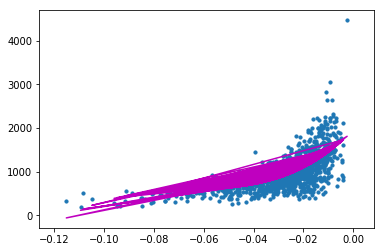

In [275]:
import operator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

this_data = df.copy()
features = ['slope_ALSFRS_Total']
target = ['death_day_since_onset']
this_data = this_data[features+target]
this_data.dropna(inplace=True)

x=this_data[features]
#x= .reshape(-1,1)
y = this_data[target]

polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print("rmse poly {}".format(rmse))
print("r2 poly {}".format(r2))


plt.scatter(x, y, s=10)
# sort the values of x before line plot
#sort_axis = operator.itemgetter(0)
#sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
#x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()


## Cluster analysis

In [115]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'Diagnosis_Delta',
       'delta_onset_diag', 'death_day_since_onset', 'death_day_mean_delta',
       'death_week', 'death_month', 'Ethnicity',
       'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Unknown', 'Race_Caucasian', 'Race_Other', 'Race_Other_Specify',
       'sex', 'age_at_onset', 'scale', 'slope', 'intercept', 'right_side',
       'left_side', 'bilateral_side', 'loc_general', 'loc_trunk', 'loc_face',
       'loc_mouth', 'loc_speech', 'loc_speech_or_mouth', 'loc_feet',
       'loc_legs_or_feet', 'loc_hands', 'loc_arms_or_hands',
       'loc_arms_and_legs', 'loc_respiratory', 'loc_neck_head', 'loc_bulbar',
       'loc_body', 'symptom_atrophy', 'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 's

In [95]:
# features to include:
features = [ 'Subject_used_Riluzole', 'death_day_since_onset', 'Race_Caucasian', 
       'sex', 'age_at_onset', 'slope', 'right_side',
       'left_side', 'bilateral_side', 'loc_general', 'loc_trunk', 'loc_face',
       'loc_mouth', 'loc_speech', 'loc_speech_or_mouth', 'loc_feet',
       'loc_legs_or_feet', 'loc_hands', 'loc_arms_or_hands',
       'loc_arms_and_legs', 'loc_respiratory', 'loc_neck_head', 'symptom_atrophy', 
        'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 'symptom_speech', 'symptom_stiffness',
       'symptom_swallowing', 'symptom_weakness',
       'weight']

potential = ['loc_bulbar', 'loc_body', 'slope_fvc_percent_of_normal']

# pick a limited number of columns from df
cluster_X = df[features].copy()
cluster_X.dropna(axis=0, inplace=True)
cluster_X.reset_index(drop=True, inplace=True)
print(cluster_X.shape)
cluster_X.head()

(653, 33)


,Subject_used_Riluzole,death_day_since_onset,Race_Caucasian,sex,age_at_onset,slope,right_side,left_side,bilateral_side,loc_general,...,symptom_cramps,symptom_fasciculations,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness,weight
0,1.0,405.0,1.0,1.0,41.808219,-0.053054,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,74.3
1,1.0,624.0,1.0,0.0,61.191781,-0.037167,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,46.7
2,0.0,825.0,1.0,0.0,70.263014,-0.011764,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.7
3,1.0,585.0,1.0,1.0,68.887671,-0.025766,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,75.0
4,1.0,656.0,1.0,1.0,71.295890,-0.012011,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,89.0


### Cluster Functions

In [144]:
def cluster(df, params):
    k=KMeans(**params).fit(df)
    result = pd.DataFrame(k.labels_, columns=["kmeans_label"])
    cluster_result = pd.concat([cluster_X, result], axis=1)
    return cluster_result

In [145]:
# plot the labels for each feature
def plot_cluster(df):
    plt.figure(figsize=(12,6))
    for col in list(df.columns):
        plt.scatter(cluster_result['death_day_since_onset'], cluster_result[col], 
                    c=cluster_result['kmeans_label'])
        plt.title(col)
        plt.show()

### cluster weight

In [112]:
# cluster weight
cluster_X = df[['weight', 'death_day_since_onset']].copy()
cluster_X.dropna(axis=0, inplace=True)
cluster_X.reset_index(drop=True, inplace=True)
print(cluster_X.shape)
cluster_X.head()

(1637, 2)


,weight,death_day_since_onset
0,63.8,1320.0
1,74.3,405.0
2,46.7,624.0
3,62.7,825.0
4,73.6,292.0


In [68]:
try:
    params = {'n_clusters':2, 'init':'k-means++', 'n_init':10, 'max_iter':300, 
              'tol':0.0001, 'precompute_distances':'auto', 'verbose':0, 
              'random_state':None, 'copy_x':True, 'n_jobs':None, 'algorithm':'auto'}
    cluster_result = cluster(cluster_X, params)
    plot_cluster(cluster_result)
except:
    print("there's an error")

there's an error


### cluster function slope

In [168]:
# cluster weight
cluster_X = df[['slope', 'death_day_since_onset']].copy()
cluster_X.dropna(axis=0, inplace=True)
cluster_X.reset_index(drop=True, inplace=True)
print(cluster_X.shape)
cluster_X.head()

(1643, 2)


,slope,death_day_since_onset
0,-0.006526,1320.0
1,-0.053054,405.0
2,-0.037167,624.0
3,-0.011764,825.0
4,-0.071534,292.0


In [169]:
# transform the negative slope
cluster_X['slope_transform'] = (cluster_X['slope'] + 1 - min(cluster_X['slope']))

In [170]:
cluster_X.head()

,slope,death_day_since_onset,slope_transform
0,-0.006526,1320.0,1.143430
1,-0.053054,405.0,1.096902
2,-0.037167,624.0,1.112789
3,-0.011764,825.0,1.138192
4,-0.071534,292.0,1.078423


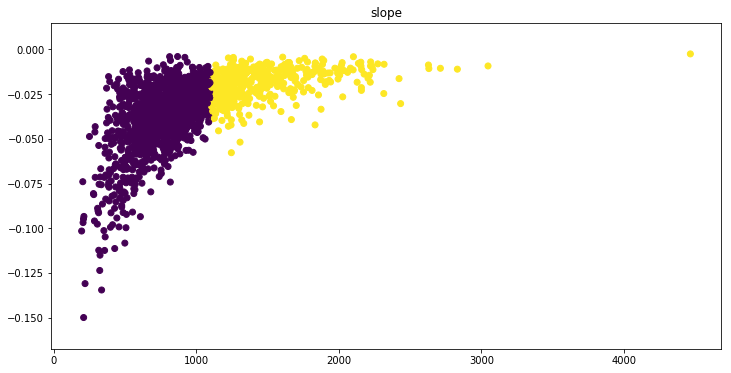

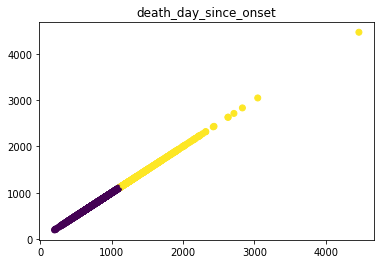

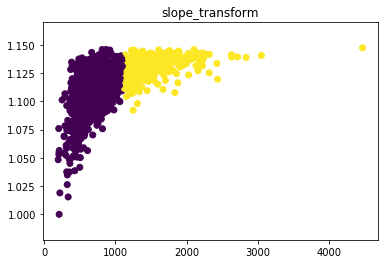

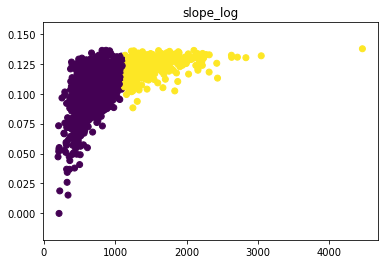

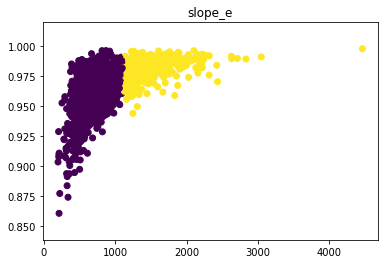

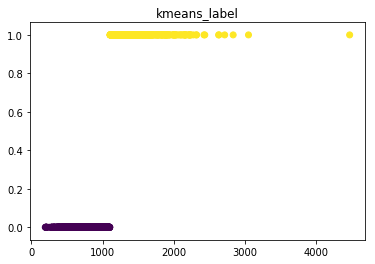

In [167]:
params = {'n_clusters':2, 'init':'k-means++', 'n_init':10, 'max_iter':300, 
          'tol':0.0001, 'precompute_distances':'auto', 'verbose':0, 
          'random_state':None, 'copy_x':True, 'n_jobs':None, 'algorithm':'auto'}
cluster_result = cluster(cluster_X, params)
plot_cluster(cluster_result)

### cluster buckets

In [118]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'Diagnosis_Delta',
       'delta_onset_diag', 'death_day_since_onset', 'death_day_mean_delta',
       'death_week', 'death_month', 'Ethnicity',
       'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Unknown', 'Race_Caucasian', 'Race_Other', 'Race_Other_Specify',
       'sex', 'age_at_onset', 'scale', 'slope', 'intercept', 'right_side',
       'left_side', 'bilateral_side', 'loc_general', 'loc_trunk', 'loc_face',
       'loc_mouth', 'loc_speech', 'loc_speech_or_mouth', 'loc_feet',
       'loc_legs_or_feet', 'loc_hands', 'loc_arms_or_hands',
       'loc_arms_and_legs', 'loc_respiratory', 'loc_neck_head', 'loc_bulbar',
       'loc_body', 'symptom_atrophy', 'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 's

In [119]:
# cluster buckets
buckets = df.merge(death_buckets, how='outer',on='subject_id')
buckets.head()

,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,...,died_2,died_3,died_4,died_5,died_6,died_7,died_8,died_9,died_10,died_greater_10
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,638.0,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,199.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
cluster_X = df[['slope', 'death_day_since_onset']].copy()
cluster_X.dropna(axis=0, inplace=True)
cluster_X.reset_index(drop=True, inplace=True)
print(cluster_X.shape)
cluster_X.head()

(1643, 2)


,slope,death_day_since_onset
0,-0.006526,1320.0
1,-0.053054,405.0
2,-0.037167,624.0
3,-0.011764,825.0
4,-0.071534,292.0


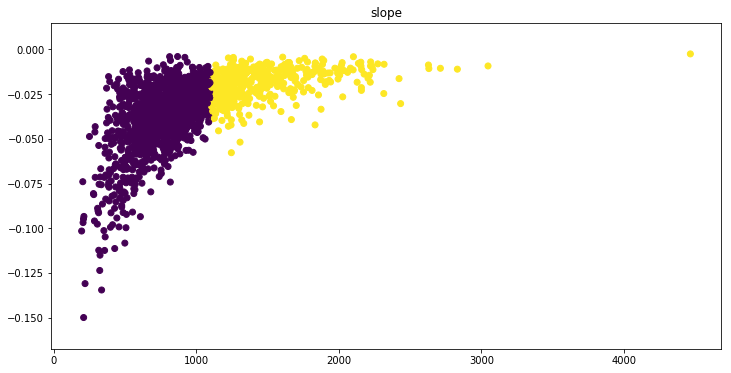

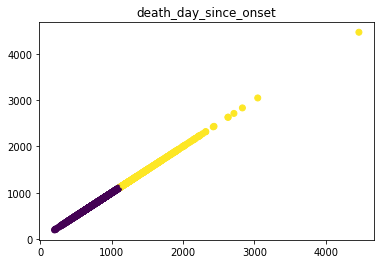

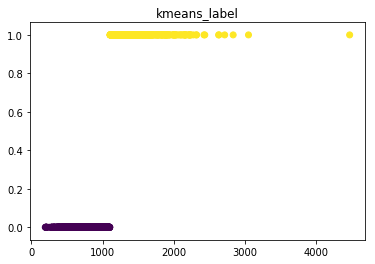

In [110]:
cluster_result = cluster(cluster_X)
plot_cluster(cluster_result)

In [ ]:
death_buckets

# Random Forest Regressor

## Predict death day: all features

In [387]:
def mean_abs_error(df, col_residuals):
    '''
    mean absolute error
    '''
    return np.abs(df[col_residuals]).mean()

In [388]:
def model_accuracy(df, col_actual, col_residuals):
    '''
    mean absolute percent error
    '''
    ape = 100 * (np.abs(df[col_residuals])/df[col_actual])
    return round(100-np.mean(ape),2)

In [389]:
def model_mse(df, col_actual, col_predicted):
    '''
    mean squared error
    '''
    mse = sum((df[col_actual]-df[col_predicted])**2)/len(df)
    return mse

In [390]:
def lm_eval(residuals_df, col_actual, col_predictions):
    '''
    model evaluation metrics and residual plots
    input: 
        residuals_df -  dataframe. contains at least test and prediction values
        col_actual -  string. column name of test values
        col_predictions -  string. column name of prediction values
    '''
    residual_df = residuals_df.copy()
    residual_df['residual'] = residual_df[col_actual] - residual_df[col_predictions]
    
    #evaluate the model
    mabs = round(mean_abs_error(residual_df, 'residual'),0)
    accur = model_accuracy(residual_df, col_actual, 'residual')
    mse = round(model_mse(residual_df, col_actual, 'residual'), 2)
    
    # output scores
    print("Mean absolute error: {} days".format(mabs))
    print("Accuracy: {} %".format(accur))
    print("MSE: {}".format(mse))
    print("RMSE: {}".format(round(np.sqrt(mse),2)))
    
    # plot histogram residuals
    plt.hist(residuals['residual'], bins=30, ec="white")
    plt.xlabel("days")
    plt.show()
    
    # plot residuals
    resid_plot(residual_df[col_predictions], residual_df['residual'])
    return 

In [391]:
df.columns[0:100]

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'delta_onset_diag',
       'death_day_since_onset', 'death_day_mean_delta', 'death_week',
       'death_month', 'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Caucasian', 'Race_Other', 'sex', 'age_trial_start_days',
       'age_at_onset', 'slope_ALSFRS_Total', 'slope_updated_ALSFRS_Total',
       'slope_ALSFRS_R_Total', 'slope_ALSFRS_Total_square',
       'slope_ALSFRS_Total_log', 'slope_ALSFRS_Total_sqrt', 'slope_Q1_Speech',
       'slope_Q1_Speech_log', 'slope_Q1_Speech_square', 'slope_Q1_Speech_sqrt',
       'slope_Q2_Salivation', 'slope_Q2_Salivation_log',
       'slope_Q2_Salivation_square', 'slope_Q2_Salivation_sqrt',
       'slope_Q3_Swallowing', 'slope_Q3_Swallowing_log',
       'slope_Q3_Swallowing_square', 'slope_Q3_Swallowing_sqrt',
       'slope_Q4_Handwriting', 'slo

In [392]:
df.columns[100:]

Index(['symptom_other', 'symptom_sensory_changes', 'symptom_speech',
       'symptom_stiffness', 'symptom_swallowing', 'symptom_weakness', 'weight',
       'slope_pct_of_Normal_Trial_1', 'slope_pct_of_Normal_Trial_1_square',
       'first_coef_updated_ALSFRS_Total', 'second_coef_updated_ALSFRS_Total',
       'third_coef_updated_ALSFRS_Total', 'first_coef_Q1_Speech',
       'second_coef_Q1_Speech', 'third_coef_Q1_Speech',
       'first_coef_Q2_Salivation', 'second_coef_Q2_Salivation',
       'third_coef_Q2_Salivation', 'first_coef_Q3_Swallowing',
       'second_coef_Q3_Swallowing', 'third_coef_Q3_Swallowing',
       'first_coef_Q4_Handwriting', 'second_coef_Q4_Handwriting',
       'third_coef_Q4_Handwriting', 'first_coef_Q6_Dressing_and_Hygiene',
       'second_coef_Q6_Dressing_and_Hygiene',
       'third_coef_Q6_Dressing_and_Hygiene', 'first_coef_Q7_Turning_in_Bed',
       'second_coef_Q7_Turning_in_Bed', 'third_coef_Q7_Turning_in_Bed',
       'first_coef_Q8_Walking', 'second_coef_Q8_W

** Comparison Data **
Number of training observations: 486
Number of test observations: 162
     test  predicted  residual
0  1177.0     1160.8      16.2
1   600.0      610.0     -10.0
2   521.0      742.7    -221.7
3   957.0      789.0     168.0
4   620.0      684.0     -64.0

Accuracy/R2 Score: 0.7266383513517549


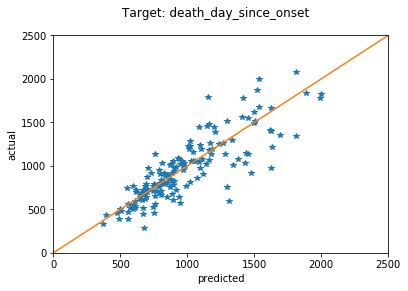

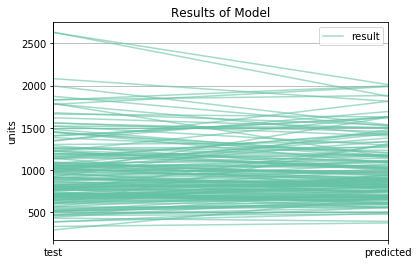

Permutation Feature Importance


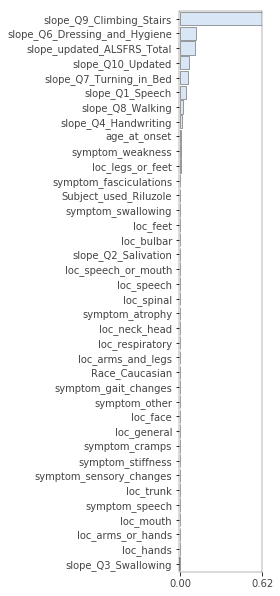

Mean absolute error: 148.0 days
Accuracy: 83.76 %
MSE: 1095420.47
RMSE: 1046.62


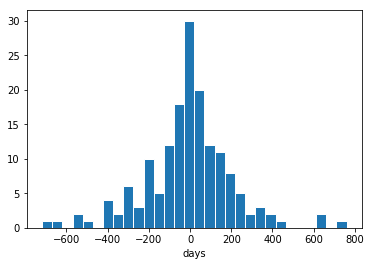

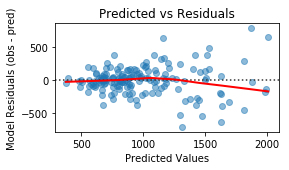

In [409]:
# limit to: none
# run RF on day to death
#this_data = 
this_data = df.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset' 

# list of feature names, must include the target.
demo_feat = [ 'Subject_used_Riluzole', 'Onset_Delta', 'delta_onset_diag',
       'death_day_since_onset', 'death_day_mean_delta', 'death_week',
       'death_month', 'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Caucasian', 'Race_Other', 'sex', 'age_trial_start_days',
       'age_at_onset', 'weight' ]

loc_side_feat = [ 'right_side', 'left_side', 'bilateral_side' ]

loc_feat = ['loc_general', 'loc_trunk', 'loc_face', 'loc_mouth', 'loc_speech',
       'loc_speech_or_mouth', 'loc_feet', 'loc_legs_or_feet', 'loc_hands',
       'loc_arms_or_hands', 'loc_arms_and_legs', 'loc_respiratory',
       'loc_neck_head', 'loc_bulbar', 'loc_spinal']
             
symptoms_feat = [
    'symptom_other', 'symptom_sensory_changes', 'symptom_speech',
    'symptom_stiffness', 'symptom_swallowing', 'symptom_weakness',
    'symptom_atrophy', 'symptom_cramps', 'symptom_fasciculations', 
    'symptom_gait_changes'
]


slopes = [
       'slope_updated_ALSFRS_Total',
       'slope_Q1_Speech',
       'slope_Q2_Salivation',
       'slope_Q3_Swallowing',
       'slope_Q4_Handwriting',
       'slope_Q6_Dressing_and_Hygiene',
       'slope_Q7_Turning_in_Bed',
       'slope_Q8_Walking',
       'slope_Q9_Climbing_Stairs',
       'slope_Q10_Updated']

'''
       'slope_ALSFRS_Total'
       'slope_ALSFRS_R_Total',
       'slope_Q10_Respiratory',
       'slope_R_1_Dyspnea',
       'slope_R_2_Orthopnea',
       'slope_R_3_Respiratory_Insufficiency',
'''



square_slopes = [
    'slope_ALSFRS_Total_square',
    'slope_Q1_Speech_square',
    'slope_Q2_Salivation_square',
    'slope_Q3_Swallowing_square',
    'slope_Q4_Handwriting_square',
    'slope_Q6_Dressing_and_Hygiene_square',
    'slope_Q7_Turning_in_Bed_square',
    'slope_Q8_Walking_square',
    'slope_Q9_Climbing_Stairs_square',
    'slope_Q10_Respiratory_square',
    'slope_Q10_Updated_square'
    'slope_R_1_Dyspnea_square',
    'slope_R_2_Orthopnea_square',
    'slope_R_3_Respiratory_Insufficiency_square'
]

log_slopes = [
    'slope_ALSFRS_Total_log',
    'slope_Q1_Speech_log',
    'slope_Q2_Salivation_log',
    'slope_Q3_Swallowing_log',
    'slope_Q4_Handwriting_log',
    'slope_Q6_Dressing_and_Hygiene_log',
    'slope_Q7_Turning_in_Bed_log',
    'slope_Q8_Walking_log',
    'slope_Q9_Climbing_Stairs_log',
    'slope_Q10_Respiratory_log',
    'slope_Q10_Updated_log',
    'slope_R_1_Dyspnea_log',
    'slope_R_2_Orthopnea_log',
    'slope_R_3_Respiratory_Insufficiency_log'
]

sqrt_slope = [
    'slope_ALSFRS_Total_sqrt',
    'slope_Q1_Speech_sqrt',
    'slope_Q2_Salivation_sqrt',
    'slope_Q3_Swallowing_sqrt',
    'slope_Q4_Handwriting_sqrt',
    'slope_Q6_Dressing_and_Hygiene_sqrt',
    'slope_Q7_Turning_in_Bed_sqrt',
    'slope_Q8_Walking_sqrt',
    'slope_Q9_Climbing_Stairs_sqrt',
    'slope_Q10_Respiratory_sqrt',
    'slope_Q10_Updated_sqrt',
    'slope_R_1_Dyspnea_sqrt',
    'slope_R_2_Orthopnea_sqrt',
    'slope_R_3_Respiratory_Insufficiency_sqrt'
]

features = [target]+slopes+symptoms_feat+loc_feat+['Subject_used_Riluzole','Race_Caucasian','age_at_onset']

#third_coef_updated_ALSFRS_Total
# limit on: None of feature name
limit_on = None

# exclude: None, string, or list
exclude_columns =   None #'loc_bulbar'

residuals, X_test, y_test = run_rf(df=this_data, features=features, class_regress=class_regress, 
       target=target, limit_on=limit_on, exclude_columns=exclude_columns)

lm_eval(residuals, 'test', 'predicted')

In [405]:
print(features)

['slope_ALSFRS_Total', 'slope_updated_ALSFRS_Total', 'slope_ALSFRS_R_Total', 'slope_Q1_Speech', 'slope_Q2_Salivation', 'slope_Q3_Swallowing', 'slope_Q4_Handwriting', 'slope_Q6_Dressing_and_Hygiene', 'slope_Q7_Turning_in_Bed', 'slope_Q8_Walking', 'slope_Q9_Climbing_Stairs', 'slope_Q10_Respiratory', 'slope_R_1_Dyspnea', 'slope_R_2_Orthopnea', 'slope_R_3_Respiratory_Insufficiency', 'slope_Q10_Updated', 'symptom_other', 'symptom_sensory_changes', 'symptom_speech', 'symptom_stiffness', 'symptom_swallowing', 'symptom_weakness', 'symptom_atrophy', 'symptom_cramps', 'symptom_fasciculations', 'symptom_gait_changes', 'loc_general', 'loc_trunk', 'loc_face', 'loc_mouth', 'loc_speech', 'loc_speech_or_mouth', 'loc_feet', 'loc_legs_or_feet', 'loc_hands', 'loc_arms_or_hands', 'loc_arms_and_legs', 'loc_respiratory', 'loc_neck_head', 'loc_bulbar', 'loc_spinal', 'Subject_used_Riluzole', 'Race_Caucasian', 'death_day_since_onset', 'age_at_onset']


** Comparison Data **
Number of training observations: 1226
Number of test observations: 409
     test  predicted  residual
0   388.0      451.8     -63.8
1   811.0     1019.4    -208.4
2  1080.0     1322.5    -242.5
3  1015.0      896.7     118.3
4  1001.0     1183.6    -182.6

Accuracy/R2 Score: 0.714257407664671


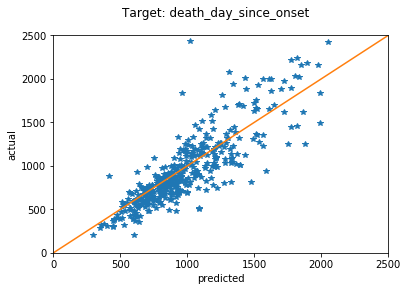

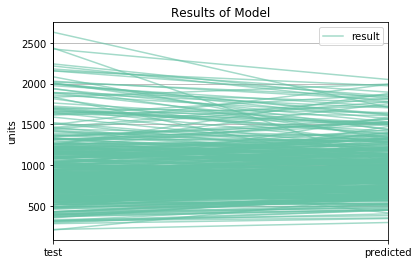

Permutation Feature Importance


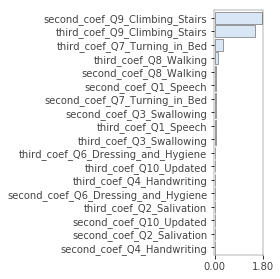

Mean absolute error: 158.0 days
Accuracy: 81.86 %
MSE: 1066524.63
RMSE: 1032.73


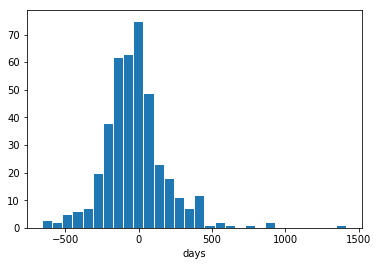

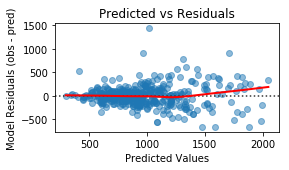

In [402]:
# limit to: none
# run RF on day to death
#this_data = 
this_data = df.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset' 

# list of feature names, must include the target.
features = ['death_day_since_onset',
       'second_coef_Q1_Speech', 'third_coef_Q1_Speech',
       'second_coef_Q2_Salivation',
       'third_coef_Q2_Salivation', 
       'second_coef_Q3_Swallowing', 'third_coef_Q3_Swallowing',
       'second_coef_Q4_Handwriting',
       'third_coef_Q4_Handwriting',
       'second_coef_Q6_Dressing_and_Hygiene',
       'third_coef_Q6_Dressing_and_Hygiene',
       'second_coef_Q7_Turning_in_Bed', 
       'third_coef_Q7_Turning_in_Bed',
       'second_coef_Q8_Walking',
       'third_coef_Q8_Walking',
       'second_coef_Q9_Climbing_Stairs', 'third_coef_Q9_Climbing_Stairs',
       'second_coef_Q10_Updated',
       'third_coef_Q10_Updated'
           ]

#third_coef_updated_ALSFRS_Total
# limit on: None of feature name
limit_on = None

# exclude: None, string, or list
exclude_columns =   None #'loc_bulbar'

residuals, X_test, y_test = run_rf(df=this_data, features=features, class_regress=class_regress, 
       target=target, limit_on=limit_on, exclude_columns=exclude_columns)

lm_eval(residuals, 'test', 'predicted')

Mean absolute error: 291.0 days
Accuracy: 66.06 %
MSE: 959824.09
RMSE: 979.71


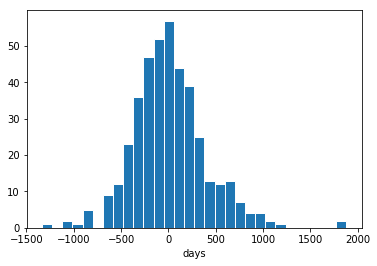

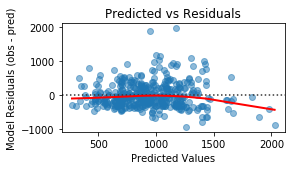

In [348]:
# mean model accuracy
all_values = mean_model(df, features, target)

NameError: name 'mean_model' is not defined

Total samples: 157
Mean absolute error: 216.0 days
Accuracy: 71.84 %
MSE: 720292.77
RMSE: 848.7


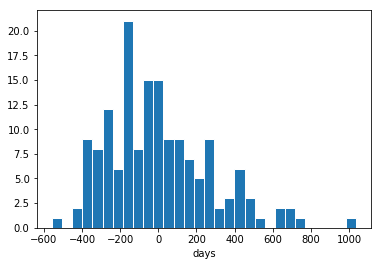

In [103]:
#accuracy bulbar
bulbar = mean_model(df, features, target, 'loc_spinal', subset_val=0)

Total samples: 491
Mean absolute error: 331.0 days
Accuracy: 61.32 %
MSE: 1015407.16
RMSE: 1007.67


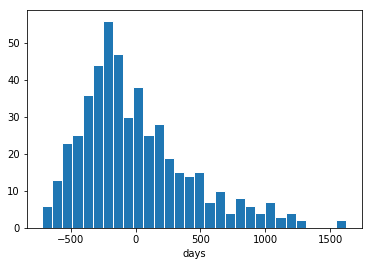

In [104]:
#accuray spinal
spinal = mean_model(df, features, target, 'loc_spinal', subset_val=1)

# Gradient Boost Regressor

## Predict death day: all features

In [72]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'delta_onset_diag',
       'death_day_since_onset', 'death_day_mean_delta', 'death_week',
       ...
       'slope_gamma-glutamyltransferase', 'slope_hematocrit',
       'slope_hemoglobin', 'slope_lymphocytes', 'slope_monocytes',
       'slope_phosphorus', 'slope_platelets', 'slope_protein',
       'slope_red blood cells (rbc)', 'slope_sodium'],
      dtype='object', length=117)

** Comparison Data **
Number of training observations: 1226
Number of test observations: 409
     test    predicted  result
0   388.0   207.548319  result
1   811.0  1033.966382  result
2  1080.0  1156.308134  result
3  1015.0   930.629929  result
4  1001.0  1208.104795  result

Accuracy/R2 Score: 0.7445045032203322


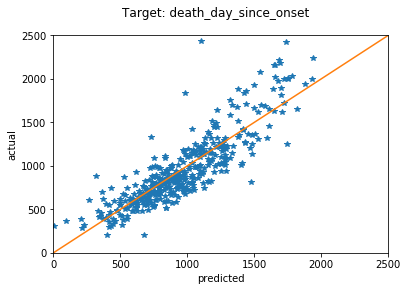

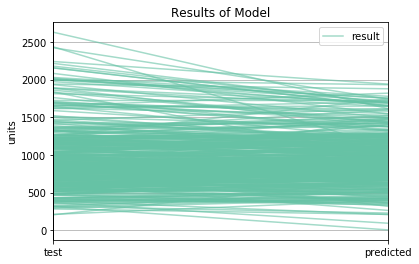

Permutation Feature Importance


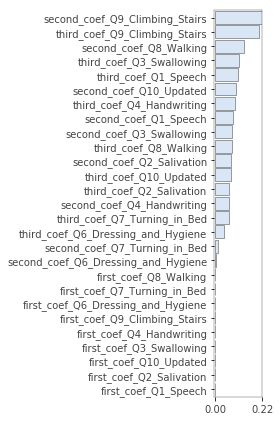

In [351]:
# limit to: none
# run gboost on day to death
this_data = df.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset'

features = features
'''['death_day_since_onset', 'Subject_used_Riluzole', 
            'Race_Caucasian', 'sex', 'age_at_onset', 'slope', 
            'right_side', 'left_side', 'bilateral_side', 'loc_bulbar', 
            'loc_spinal', 'slope_Q1_Speech', 'slope_Q2_Salivation', 'slope_Q3_Swallowing',
       'slope_Q4_Handwriting', 'slope_Q6_Dressing_and_Hygiene',
       'slope_Q7_Turning_in_Bed', 'slope_Q8_Walking',
       'slope_Q9_Climbing_Stairs']
'''
# limit on: None of feature name
limit_on = None 

# exclude: None, string, or list
exclude_columns =  None

# set model params
params = {'learning_rate': 0.1, 'max_features': 5, 'min_samples_leaf': 6, 
          'min_samples_split': 8, 'n_estimators': 350}

run_gboost(this_data, features, class_regress, target, limit_on, exclude_columns, params)

In [350]:
# run the data with grid search
# set crossvalidation parameters
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_features': [3, 4, 5],
    'min_samples_leaf': [3, 4, 6],
    'min_samples_split': [4, 8, 10, 15],
    'n_estimators': [ 150, 200, 250, 350]
}


run_cv_gboost(df, features, class_regress, target, limit_on, exclude_columns, param_grid)


Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   26.9s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   50.5s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 1296 out of 1296 | elapsed:  3.0min finished


{'learning_rate': 0.1, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 350}


## Predict day of death using: symptom_weakness

** Comparison Data **
Number of training observations: 418
Shape of test: (140, 3)
     test  predicted  result
0   520.0      620.2  result
1   598.0      760.6  result
2   978.0      856.3  result
3   638.0      644.0  result
4  1408.0     1781.5  result

Accuracy/R2 Score: 0.7793151794365991


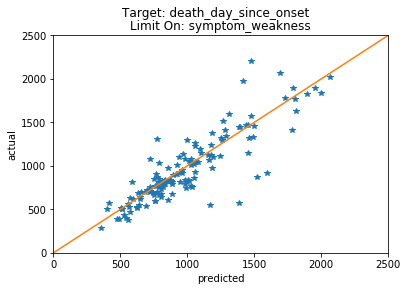

Permutation Feature Importance


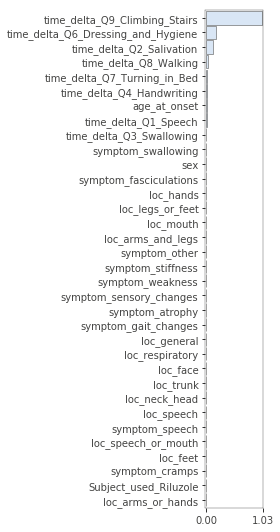

In [142]:
# limit to: symptom_weakness
# run RF on day to death
this_data = model_data.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset'
limit_on = 'symptom_weakness'    # None of feature name
exclude_columns = 'slope'

run_rf(this_data, class_regress, target, limit_on, exclude_columns)

## Predict day of death using: loc_hands

** Comparison Data **
Number of training observations: 111
Shape of test: (37, 3)
     test  predicted  result
0  1564.0     1398.0  result
1   519.0      634.7  result
2  1312.0     1556.5  result
3  1498.0     1918.2  result
4   864.0      898.8  result

Accuracy/R2 Score: 0.6782941620093093


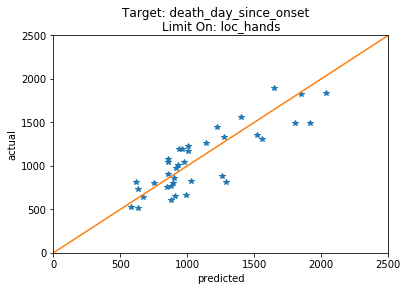

Permutation Feature Importance


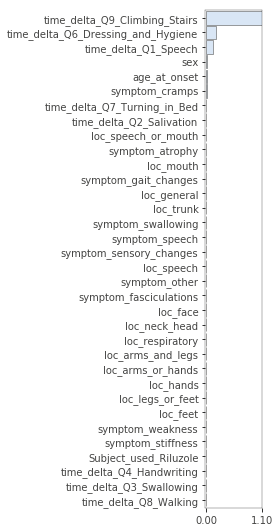

In [141]:
# limit to: loc_hands
# run RF on day to death
this_data = model_data.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset'
limit_on = 'loc_hands'    # None of feature name
exclude_columns = 'slope'

run_rf(this_data, class_regress, target, limit_on, exclude_columns)

## Bayesian Linear Regression

In [207]:
data = 'this'

In [213]:
# EXAMPLE from this site: https://docs.pymc.io/notebooks/getting_started
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variables
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

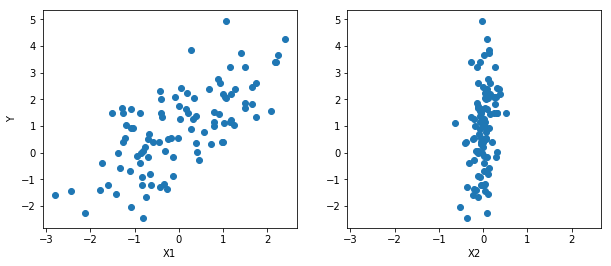

In [214]:
# EXAMPLE
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

In [215]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.6


In [ ]:
# EXAMPLE
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    # this is a deterministic random variable, which implies that its 
    # value is completely determined by its parents’ values.
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

In [ ]:
# model fitting
#Most techniques for finding the MAP estimate also only find a local optimum, which is ok most times.
map_estimate = pm.find_MAP(model=basic_model)  #, method='powell'   # 'powell': an alternative MAP alogorithm
map_estimate

In [ ]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)

In [ ]:
trace['alpha'][-5:]

In [ ]:
pm.traceplot(trace);

In [ ]:
pm.summary(trace).round(2)

#### Example 2 - generalized linear bayesian model

In [48]:
# EXAMPLE 2
from pymc3.glm import GLM

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [49]:
# my data
this_data = df.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset'

features = ['death_day_since_onset', 'Subject_used_Riluzole', 
            'Race_Caucasian', 'sex', 'age_at_onset', 'slope', 
            'right_side', 'left_side', 'bilateral_side', 'loc_bulbar', 
            'loc_spinal', 'slope_Q1_Speech', 'slope_Q2_Salivation', 'slope_Q3_Swallowing',
       'slope_Q4_Handwriting', 'slope_Q6_Dressing_and_Hygiene',
       'slope_Q7_Turning_in_Bed', 'slope_Q8_Walking',
       'slope_Q9_Climbing_Stairs']

In [ ]:
for f in features:
    if f==target:
        r_form = features[0]+' ~ '
    text_feat = ' + '.join(f)
    r_form = r_form.join(text_feat)

In [ ]:
r_form

In [223]:
bm_df = this_data[features].copy()
bm_df.dropna(inplace=True)
print(bm_df.shape)
bm_df.head()

(648, 19)


,death_day_since_onset,Subject_used_Riluzole,Race_Caucasian,sex,age_at_onset,slope,right_side,left_side,bilateral_side,loc_bulbar,loc_spinal,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs
22,405.0,1.0,1.0,1.0,41.808219,-0.053054,1.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,-0.003750,-0.008464,-0.011028,-0.011028,-0.011285
32,624.0,1.0,1.0,0.0,61.191781,-0.037167,1.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,-0.002479,-0.006924,-0.007282,-0.007282,-0.007386
34,825.0,0.0,1.0,0.0,70.263014,-0.011764,0.0,0.0,0.0,1.0,0.0,-0.002704,-0.003054,-0.002016,0.000000,0.000000,0.000000,-0.000509,-0.001899
48,585.0,1.0,1.0,1.0,68.887671,-0.025766,0.0,0.0,0.0,1.0,1.0,-0.005190,-0.008746,-0.005256,-0.000952,-0.001533,-0.000952,0.000000,0.000000
65,656.0,1.0,1.0,1.0,71.295890,-0.012011,1.0,1.0,1.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-0.000309,0.000000,-0.003534,-0.005300


In [218]:
# EXAMPLE 2
bm_df = pd.DataFrame({'x1': X1, 'x2': X2, 'y': Y})
with pm.Model() as model_glm:
    GLM.from_formula('y ~ x1 + x2', bm_df)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x2, x1, Intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:06<00:00, 301.64draws/s]


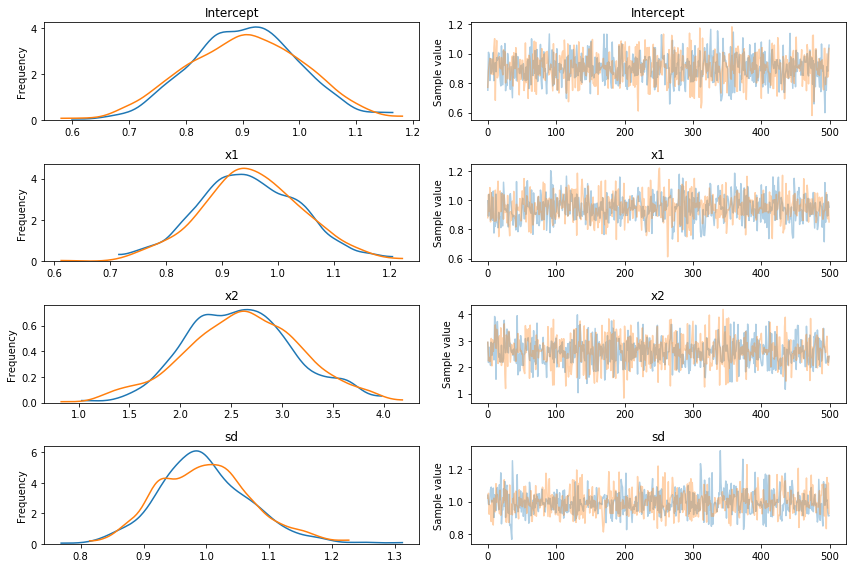

In [220]:
pm.traceplot(trace)
plt.show()

# Random Forest Classifier

## Predict death year bucket: all features

In [125]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'delta_onset_diag',
       'death_day_since_onset', 'death_day_mean_delta', 'death_week',
       'death_month', 'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Caucasian', 'Race_Other', 'sex', 'age_trial_start_days',
       'age_at_onset', 'scale', 'slope', 'intercept', 'right_side',
       'left_side', 'bilateral_side', 'loc_general', 'loc_trunk', 'loc_face',
       'loc_mouth', 'loc_speech', 'loc_speech_or_mouth', 'loc_feet',
       'loc_legs_or_feet', 'loc_hands', 'loc_arms_or_hands',
       'loc_arms_and_legs', 'loc_respiratory', 'loc_neck_head', 'loc_bulbar',
       'loc_spinal', 'symptom_atrophy', 'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 'symptom_speech', 'symptom_stiffness',
       'sympto

** Comparison Data **
Number of training observations: 409
Number of test observations: 137
   test  predicted  result
0   1.0        1.0  result
1   0.0        0.0  result
2   0.0        0.0  result
3   0.0        0.0  result
4   1.0        1.0  result

Accuracy/R2 Score: 0.9197080291970803
Cross Val Scores: [0.8902439  0.96341463 0.90243902 0.90243902 0.88888889]
Mean Cross Val Score: 0.9094850948509485
** Confusion Matrix **
                Actual      
                  True False
Predicted True      10     0
          False     11   116

** F1 Score **
F1 = 2 * (precision * recall) / (precision + recall)
F1 Score: 64.52%


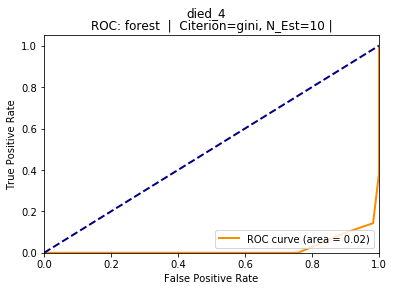

Permutation Feature Importance


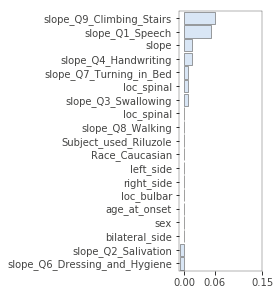

In [139]:
# limit to: none
# run RF on day to death
this_data = df.copy()
class_regress = 'classifier'    # regression or classifier

# targets, limits
target = 'died_4'

# include the target
features = ['died_4', 'Subject_used_Riluzole', 'Race_Caucasian', 'sex', 'age_at_onset', 
            'slope', 'loc_bulbar', 'loc_spinal',
            'right_side', 'left_side', 'bilateral_side',
            'loc_spinal', 'slope_Q1_Speech', 'slope_Q2_Salivation', 'slope_Q3_Swallowing',
            'slope_Q4_Handwriting', 'slope_Q6_Dressing_and_Hygiene',
            'slope_Q7_Turning_in_Bed', 'slope_Q8_Walking', 'slope_Q9_Climbing_Stairs']

# limit on: None of feature name
limit_on = None 

# exclude: None, string, or list
exclude_columns = None

run_rf(df=this_data, features=features, class_regress=class_regress, 
       target=target, limit_on=limit_on, exclude_columns=exclude_columns)

# Plotting Model Stuff

In [106]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Scatterpolar(
  r = [39, 28, 8, 7, 28, 39],
  theta = ['A','B','C', 'D', 'E', 'A'],
  fill = 'toself'
)]

layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 50]
    )
  ),
  showlegend = False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = "radar/basic")

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

## Radar plot

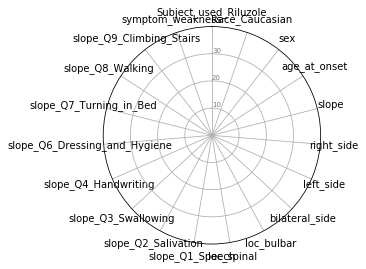

In [122]:
# ------- PART 1: Create background

# number of variable
#ff = features.copy()
#ff.remove(target)
this_data = df[features].copy()
categories=list(this_data)[1:]  # target should be first feature, or adjust to zero
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)
plt.show()

In [123]:
pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})


,group,var1,var2,var3,var4,var5
0,A,38.0,29,8,7,28
1,B,1.5,10,39,31,15
2,C,30.0,9,23,33,32
3,D,4.0,34,24,14,14


In [ ]:
# ------- PART 2: Add plots

# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable

# Group1
values=this_data.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
ax.fill(angles, values, 'b', alpha=0.1)

In [ ]:
# Ind2
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
ax.fill(angles, values, 'r', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Linear Regression

In [157]:
this_data = df.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset'

# list of feature names, must include the target.
features = ['Subject_used_Riluzole', 
            'Race_Caucasian', 'sex', 'age_at_onset', 'slope', 
            'right_side', 'left_side', 'bilateral_side', 'loc_bulbar', 
            'loc_spinal', 'slope_Q1_Speech', 'slope_Q2_Salivation', 'slope_Q3_Swallowing',
           'slope_Q4_Handwriting', 'slope_Q6_Dressing_and_Hygiene',
           'slope_Q7_Turning_in_Bed', 'slope_Q8_Walking',
           'slope_Q9_Climbing_Stairs', 'symptom_weakness', 'slope_fvc_liters']

# limit on: None of feature name
limit_on = None

# exclude: None, string, or list
exclude_columns = None

In [169]:
# polynomial regression
import operator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

targetfeatures = [target] + features
this_data=this_data[targetfeatures].copy()
this_data.dropna(inplace=True)

y=np.array(this_data[target]).reshape(-1,1)
x=np.array(this_data[features])

polynomial_features= PolynomialFeatures(degree=1)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print("rmse poly {}".format(rmse))
print("r2 poly {}".format(r2))

rmse poly 275.64803870588065
r2 poly 0.5065831851288225


ValueError: x and y must be the same size

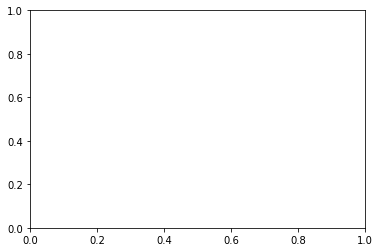

In [170]:
plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()